In [18]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("../src")
import feature.scrna_dataset as scrna_dataset
import model.sdes as sdes
import model.generate as generate
import model.scrna_ae as scrna_ae
import model.util as model_util
import torch
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import os
import h5py

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Define device
if torch.cuda.is_available():
    DEVICE = "cuda"
else:
    DEVICE = "cpu"

### Define the branches and create the data loader

In [3]:
classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]

branch_defs = [((0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14), 6.446446446446447e-01, 1), ((0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14), 0.6316316316316316, 0.6446446446446447), ((0, 1, 2, 3, 4, 6, 7, 8, 10, 11, 12, 13, 14), 0.5925925925925926, 0.6316316316316316), ((0, 1, 2, 3, 4, 6, 7, 8, 10, 11, 12, 14), 0.4854854854854855, 0.5925925925925926), ((1, 2, 3, 4, 6, 7, 8, 11, 12, 14), 0.44844844844844844, 0.4854854854854855), ((0, 10), 0.44544544544544545, 0.4854854854854855), ((1, 2, 3, 4, 6, 7, 8, 12, 14), 0.43043043043043044, 0.44844844844844844), ((1, 2, 4, 6, 7, 12, 14), 0.40040040040040037, 0.43043043043043044), ((1, 2, 4, 6, 7, 12), 0.3733733733733734, 0.40040040040040037), ((3, 8), 0.3683683683683684, 0.43043043043043044), ((4, 7, 12), 0.3313313313313313, 0.3733733733733734), ((1, 2, 6), 0.2932932932932933, 0.3733733733733734), ((1, 2), 0.27427427427427425, 0.2932932932932933), ((4, 7), 0.12512512512512514, 0.3313313313313313), ((5,), 0, 0.6446446446446447), ((9,), 0, 0.6316316316316316), ((13,), 0, 0.5925925925925926), ((11,), 0, 0.44844844844844844), ((0,), 0, 0.44544544544544545), ((10,), 0, 0.44544544544544545), ((14,), 0, 0.40040040040040037), ((8,), 0, 0.3683683683683684), ((3,), 0, 0.3683683683683684), ((12,), 0, 0.3313313313313313), ((6,), 0, 0.2932932932932933), ((2,), 0, 0.27427427427427425), ((1,), 0, 0.27427427427427425), ((4,), 0, 0.12512512512512514), ((7,), 0, 0.12512512512512514)]
# branch_defs = [((0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14), 0, 1)]

classes = [0, 1, 2, 3, 4, 5, 7, 10, 12]
branch_defs = [((0, 1, 2, 3, 4, 5, 7, 10, 12), 6.436436436436437e-01, 1), ((0, 1, 2, 3, 4, 7, 10, 12), 0.5405405405405406, 0.6436436436436437), ((1, 2, 3, 4, 7, 12), 0.5085085085085085, 0.5405405405405406), ((0, 10), 0.45045045045045046, 0.5405405405405406), ((1, 2, 4, 7, 12), 0.37237237237237236, 0.5085085085085085), ((4, 7, 12), 0.36436436436436437, 0.37237237237237236), ((1, 2), 0.22922922922922923, 0.37237237237237236), ((4, 7), 0.1841841841841842, 0.36436436436436437), ((5,), 0, 0.6436436436436437), ((3,), 0, 0.5085085085085085), ((0,), 0, 0.45045045045045046), ((10,), 0, 0.45045045045045046), ((12,), 0, 0.36436436436436437), ((1,), 0, 0.22922922922922923), ((2,), 0, 0.22922922922922923), ((7,), 0, 0.1841841841841842), ((4,), 0, 0.1841841841841842)]

In [20]:
data_file = "/gstore/data/resbioai/tsenga5/branched_diffusion/data/scrna/covid_flu/processed/covid_flu_processed_reduced_genes.h5"

dataset = scrna_dataset.SingleCellDataset(data_file)

# Limit classes
inds = np.isin(dataset.cell_cluster, classes)
dataset.data = dataset.data[inds]
dataset.cell_cluster = dataset.cell_cluster[inds]

data_loader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=True, num_workers=0)
input_shape = next(iter(data_loader))[0].shape[1:]

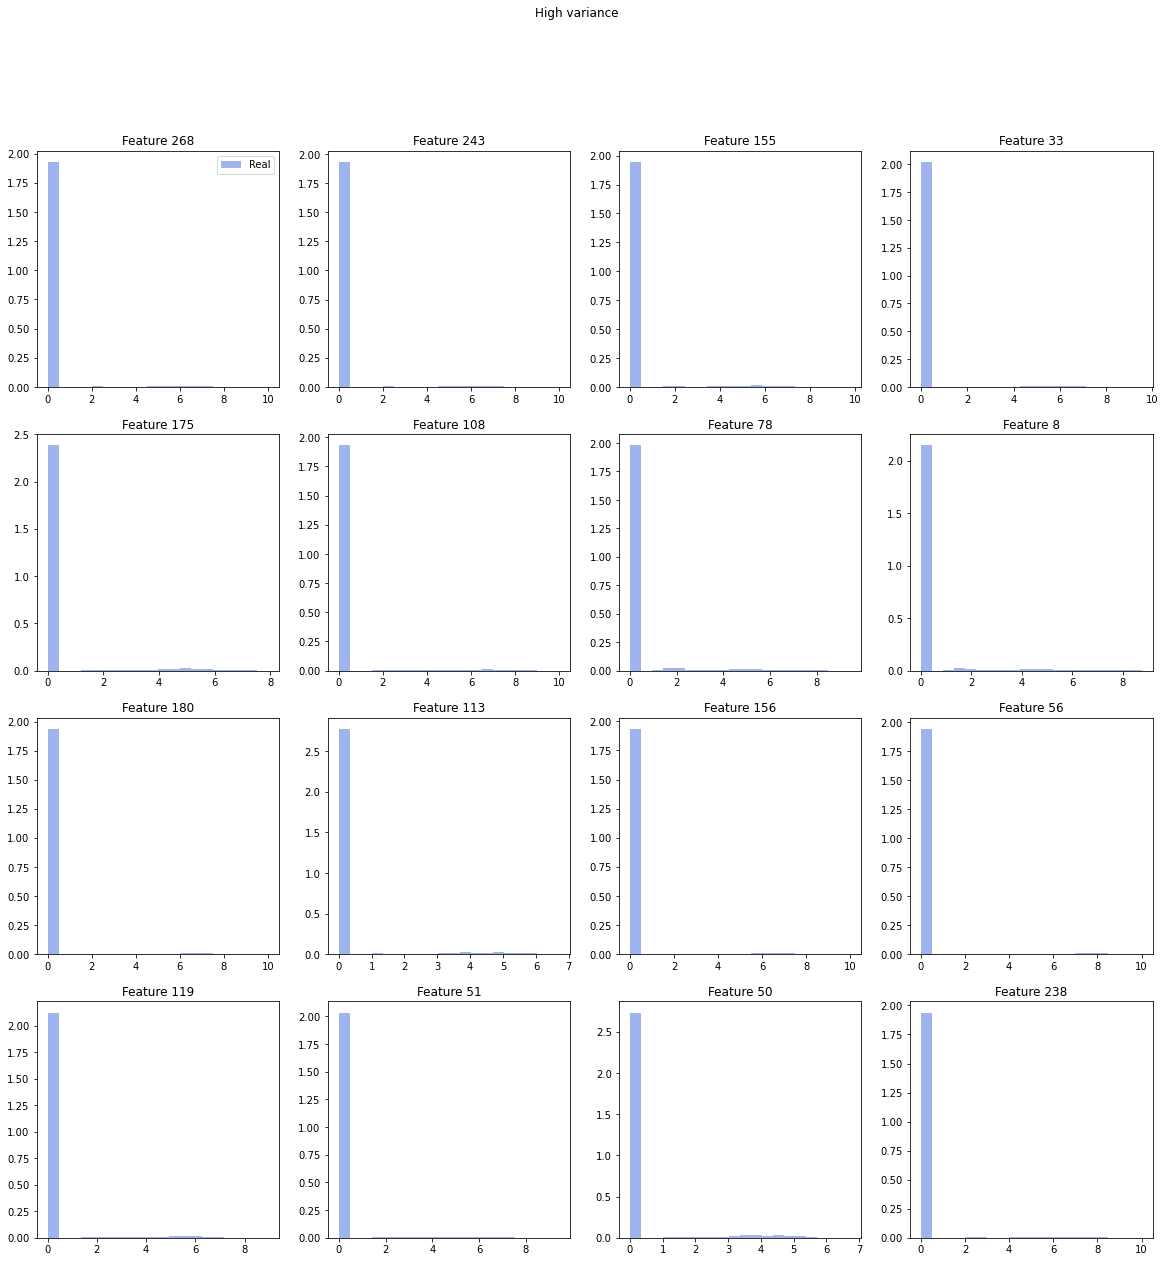

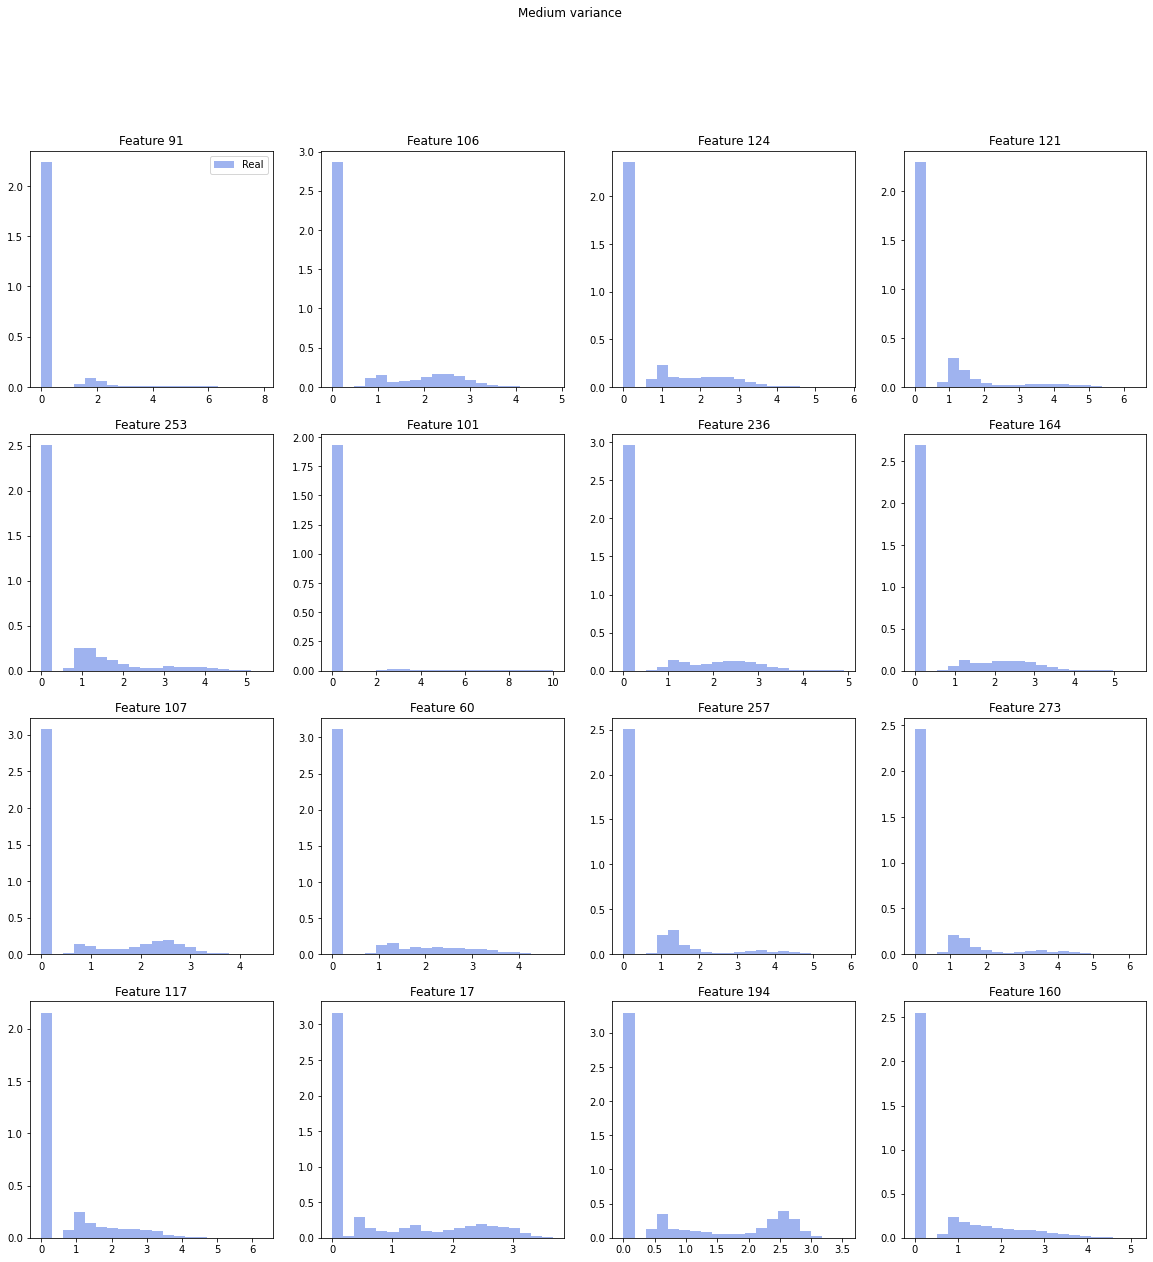

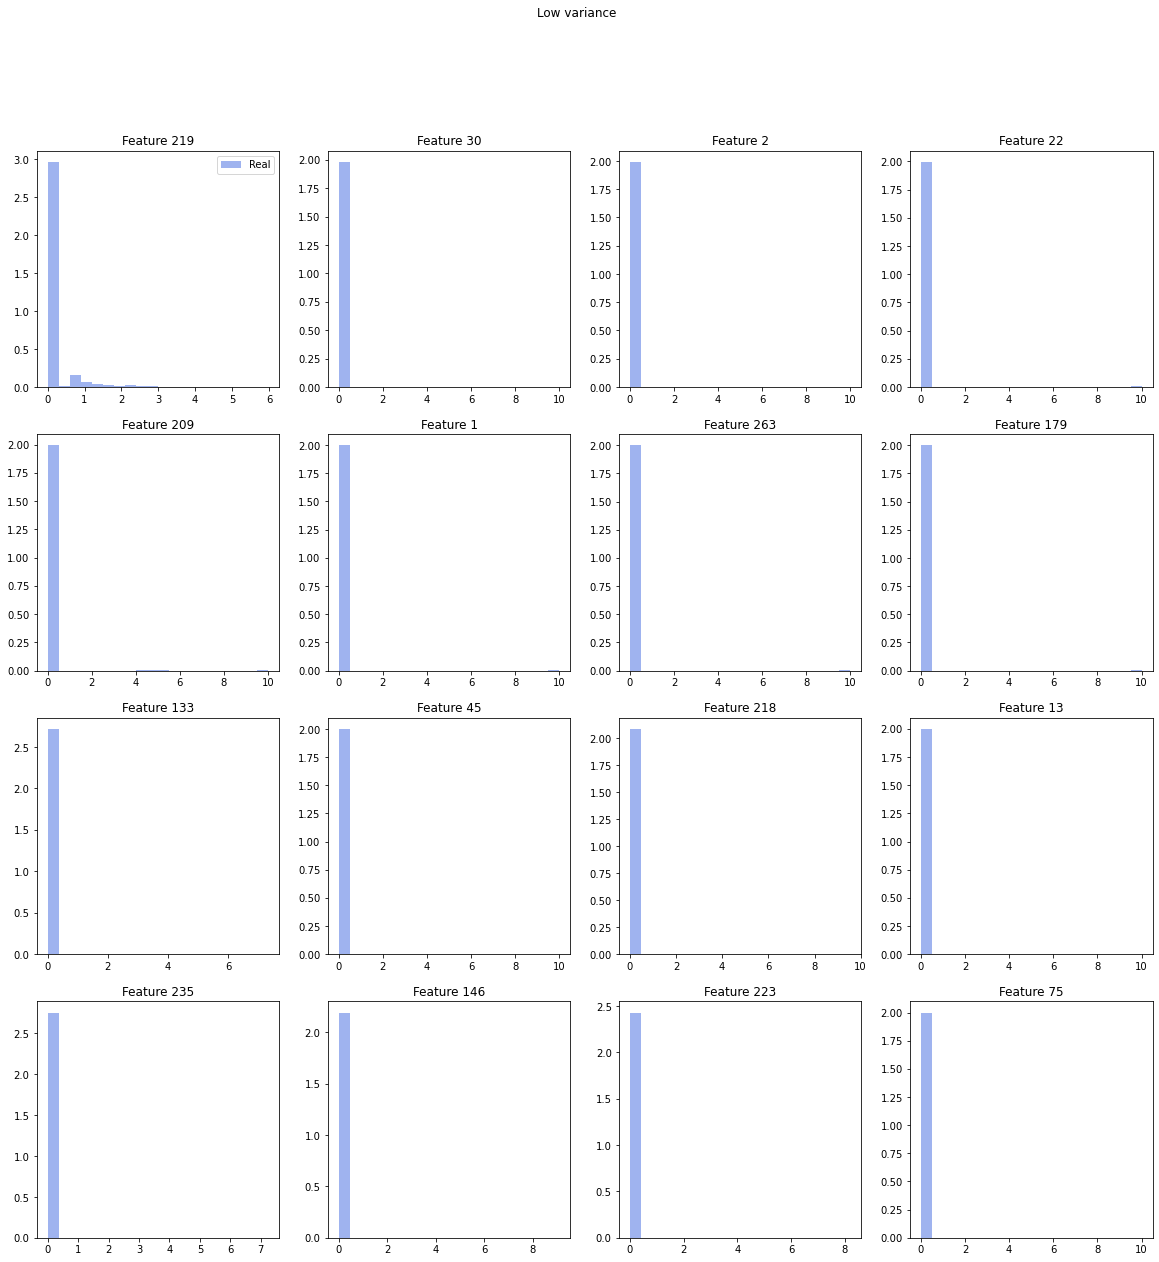

In [5]:
# Plot features
x = dataset.data
inds = np.flip(np.argsort(np.std(x, axis=0)))
num_features = 16
num_cols = 4
num_rows = int(np.ceil(num_features / num_cols))
num_bins = 20

for name, feature_inds in [
    ("High variance", inds[:num_features]),
    ("Medium variance", inds[(len(inds) // 2) - (num_features // 2):(len(inds) // 2) - (num_features // 2) + num_features]),
    ("Low variance", inds[-num_features:])
]:
    fig, ax = plt.subplots(ncols=num_cols, nrows=num_rows, figsize=(num_cols * 5, num_rows * 5))
    for i, f_i in enumerate(feature_inds):
        r, c = i // num_cols, i % num_cols
        vals = x[:, f_i]
        ax[r][c].hist(vals, bins=num_bins, color="royalblue", label="Real", density=True, alpha=0.5)
        ax[r][c].set_title("Feature %d" % f_i)
    ax[0][0].legend()
    fig.suptitle(name)
    plt.show()

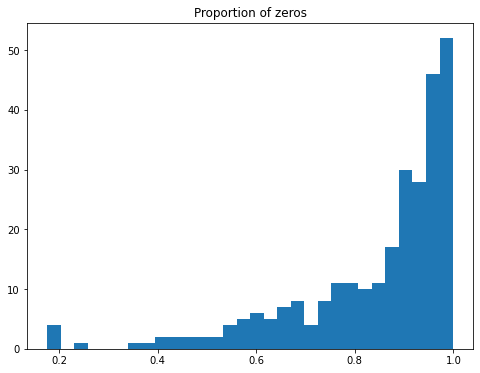

In [6]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(np.sum(x == 0, axis=0) / x.shape[0], bins=30)
ax.set_title("Proportion of zeros")
plt.show()

In [7]:
epsilon = 1e-1
feature_weights = torch.tensor(np.maximum(1 - (np.sum(x == 0, axis=0) / x.shape[0]), epsilon)).to(DEVICE)

In [8]:
# TODO: this is currently rather inefficient; a decision-tree-style structure
# would be better

def class_time_to_branch(c, t):
    """
    Given a class and a time (both scalars), return the
    corresponding branch index.
    """
    for i, branch_def in enumerate(branch_defs):
        if c in branch_def[0] and t >= branch_def[1] and t <= branch_def[2]:
            return i
    raise ValueError("Undefined class and time")
        
def class_time_to_branch_tensor(c, t):
    """
    Given tensors of classes and a times, return the
    corresponding branch indices as a tensor.
    """
    return torch.tensor([
        class_time_to_branch(c_i, t_i) for c_i, t_i in zip(c, t)
    ], device=DEVICE)

In [9]:
# Create the SDE and model
sde = sdes.VariancePreservingSDE(0.1, 5, input_shape)

t_limit = 1

model = scrna_ae.MultitaskResNet(
    len(branch_defs), input_shape[0], t_limit=t_limit
).to(DEVICE)

os.environ["MODEL_DIR"] = "/gstore/data/resbioai/tsenga5/branched_diffusion/models/trained_models/scrna_covid_flu_continuous_allcells"
import model.train_continuous_model as train_continuous_model  # Import this AFTER setting environment

### Show the forward-diffusion process

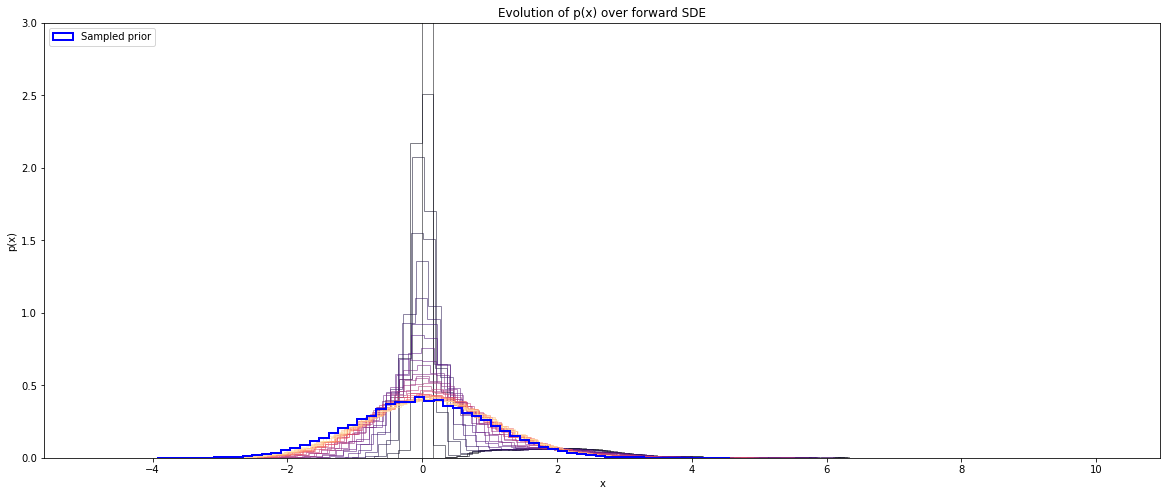

In [10]:
# Show the transformation of the distribution of data to the prior distribution
x0, _ = next(iter(data_loader))
x0 = x0.cpu().numpy()
x0 = torch.tensor(x0).to(DEVICE)

time_steps = 30

all_t = np.linspace(0, t_limit, time_steps)
all_xt = np.empty((len(all_t),) + x0.shape)
for t_i, t in enumerate(all_t):
    xt, _ = sde.forward(x0, torch.ones(len(x0)).to(DEVICE) * t)
    all_xt[t_i] = xt.cpu().numpy()

fig, ax = plt.subplots(figsize=(20, 8))
cmap = plt.get_cmap("magma")
for t_i in range(len(all_t)):
    ax.hist(np.ravel(all_xt[t_i]), bins=60, histtype="step", color=cmap(t_i / len(all_t)), alpha=0.5, density=True)
prior = sde.sample_prior(len(x0), torch.ones(len(x0)).to(DEVICE) * t).cpu().numpy()
ax.hist(np.ravel(prior), bins=60, histtype="step", color="blue", linewidth=2, density=True, label="Sampled prior")
ax.set_xlabel("x")
ax.set_ylabel("p(x)")
ax.set_title("Evolution of p(x) over forward SDE")
ax.set_ylim((0, 3))
plt.legend()
plt.show()

### Train the model

In [11]:
train_continuous_model.train_ex.run(
    "train_branched_model",
    config_updates={
        "model": model,
        "sde": sde,
        "data_loader": data_loader,
        "class_time_to_branch_index": class_time_to_branch_tensor,
        "num_epochs": 300,
        "learning_rate": 1e-3,
        "t_limit": t_limit,
        "loss_weighting_type": "empirical_norm",
        "feature_weights": feature_weights
    }
)

WARNING - root - Added new config entry: "class_time_to_branch_index"
WARNING - root - Added new config entry: "data_loader"
WARNING - root - Added new config entry: "feature_weights"
WARNING - root - Added new config entry: "loss_weighting_type"
WARNING - root - Added new config entry: "model"
WARNING - root - Added new config entry: "sde"
WARNING - root - Added new config entry: "t_limit"
INFO - train - Running command 'train_branched_model'
INFO - train - Started run with ID "1"
Loss: 37.28: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [01:56<00:00,  2.14it/s]


Epoch 1 average Loss: 53.76


Loss: 28.34: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [01:57<00:00,  2.13it/s]


Epoch 2 average Loss: 28.90


Loss: 23.46: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [01:58<00:00,  2.10it/s]


Epoch 3 average Loss: 25.17


Loss: 22.83: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [02:21<00:00,  1.76it/s]


Epoch 4 average Loss: 23.46


Loss: 22.00: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [02:09<00:00,  1.93it/s]


Epoch 5 average Loss: 22.39


Loss: 18.28: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [01:56<00:00,  2.14it/s]


Epoch 6 average Loss: 21.53


Loss: 18.11: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [01:56<00:00,  2.13it/s]


Epoch 7 average Loss: 20.94


Loss: 23.26: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [01:56<00:00,  2.14it/s]


Epoch 8 average Loss: 20.54


Loss: 23.38: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [01:56<00:00,  2.14it/s]


Epoch 9 average Loss: 20.04


Loss: 17.97: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [01:56<00:00,  2.14it/s]


Epoch 10 average Loss: 19.78


Loss: 20.19: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [01:56<00:00,  2.14it/s]


Epoch 11 average Loss: 19.49


Loss: 19.35: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [01:56<00:00,  2.14it/s]


Epoch 12 average Loss: 19.25


Loss: 18.10: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [01:56<00:00,  2.14it/s]


Epoch 13 average Loss: 18.99


Loss: 19.49: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [01:56<00:00,  2.14it/s]


Epoch 14 average Loss: 18.84


Loss: 18.16: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [01:56<00:00,  2.14it/s]


Epoch 15 average Loss: 18.62


Loss: 20.17: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [02:41<00:00,  1.54it/s]


Epoch 16 average Loss: 18.49


Loss: 17.51: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [01:56<00:00,  2.14it/s]


Epoch 17 average Loss: 18.42


Loss: 17.00: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [01:56<00:00,  2.14it/s]


Epoch 18 average Loss: 18.20


Loss: 19.44: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [01:56<00:00,  2.14it/s]


Epoch 19 average Loss: 17.97


Loss: 19.52: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [01:56<00:00,  2.14it/s]


Epoch 20 average Loss: 17.92


Loss: 17.07: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [01:56<00:00,  2.14it/s]


Epoch 21 average Loss: 17.83


Loss: 17.22: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [01:56<00:00,  2.14it/s]


Epoch 22 average Loss: 17.58


Loss: 16.21: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [01:56<00:00,  2.14it/s]


Epoch 23 average Loss: 17.51


Loss: 15.59: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [01:56<00:00,  2.14it/s]


Epoch 24 average Loss: 17.33


Loss: 18.47: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [01:56<00:00,  2.14it/s]


Epoch 25 average Loss: 17.18


Loss: 18.03: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [01:56<00:00,  2.14it/s]


Epoch 26 average Loss: 17.01


Loss: 17.13: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [01:56<00:00,  2.14it/s]


Epoch 27 average Loss: 16.97


Loss: 15.66: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [01:56<00:00,  2.14it/s]


Epoch 28 average Loss: 16.83


Loss: 20.59: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [01:56<00:00,  2.14it/s]


Epoch 29 average Loss: 16.74


Loss: 20.18: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [01:56<00:00,  2.14it/s]


Epoch 30 average Loss: 16.72


Loss: 16.19: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [01:56<00:00,  2.14it/s]


Epoch 31 average Loss: 16.54


Loss: 15.81: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [01:56<00:00,  2.14it/s]


Epoch 32 average Loss: 16.48


Loss: 18.37: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [01:56<00:00,  2.14it/s]


Epoch 33 average Loss: 16.47


Loss: 14.13: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [01:56<00:00,  2.14it/s]


Epoch 34 average Loss: 16.28


Loss: 15.93: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [01:56<00:00,  2.14it/s]


Epoch 35 average Loss: 16.19


Loss: 16.09: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [01:56<00:00,  2.14it/s]


Epoch 36 average Loss: 16.08


Loss: 15.01: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [01:56<00:00,  2.14it/s]


Epoch 37 average Loss: 15.96


Loss: 16.27: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [01:56<00:00,  2.14it/s]


Epoch 38 average Loss: 15.80


Loss: 16.84: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [01:56<00:00,  2.14it/s]


Epoch 39 average Loss: 15.58


Loss: 16.31: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [01:56<00:00,  2.14it/s]


Epoch 40 average Loss: 15.69


Loss: 13.90: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [01:56<00:00,  2.14it/s]


Epoch 41 average Loss: 15.54


Loss: 16.24: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [02:46<00:00,  1.50it/s]


Epoch 42 average Loss: 15.57


Loss: 16.52: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [02:18<00:00,  1.80it/s]


Epoch 43 average Loss: 15.47


Loss: 15.29: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [01:56<00:00,  2.14it/s]


Epoch 44 average Loss: 15.40


Loss: 17.10: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [01:56<00:00,  2.14it/s]


Epoch 45 average Loss: 15.39


Loss: 14.70: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [01:56<00:00,  2.14it/s]


Epoch 46 average Loss: 15.16


Loss: 17.47: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [01:56<00:00,  2.14it/s]


Epoch 47 average Loss: 15.22


Loss: 14.72: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [01:56<00:00,  2.14it/s]


Epoch 48 average Loss: 15.16


Loss: 16.69: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [01:56<00:00,  2.14it/s]


Epoch 49 average Loss: 14.99


Loss: 16.56: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [01:56<00:00,  2.14it/s]


Epoch 50 average Loss: 15.08


Loss: 16.81: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [01:56<00:00,  2.14it/s]


Epoch 51 average Loss: 14.85


Loss: 14.82: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [01:56<00:00,  2.14it/s]


Epoch 52 average Loss: 14.99


Loss: 16.19: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [01:56<00:00,  2.14it/s]


Epoch 53 average Loss: 14.84


Loss: 15.45: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [01:56<00:00,  2.14it/s]


Epoch 54 average Loss: 14.98


Loss: 16.63: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [01:56<00:00,  2.14it/s]


Epoch 55 average Loss: 14.74


Loss: 14.11: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [01:56<00:00,  2.14it/s]


Epoch 56 average Loss: 14.80


Loss: 13.44: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [01:56<00:00,  2.14it/s]


Epoch 57 average Loss: 14.63


Loss: 13.54: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [01:56<00:00,  2.14it/s]


Epoch 58 average Loss: 14.54


Loss: 14.63: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [01:56<00:00,  2.14it/s]


Epoch 59 average Loss: 14.56


Loss: 15.89: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [01:56<00:00,  2.14it/s]


Epoch 60 average Loss: 14.59


Loss: 17.09: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [01:56<00:00,  2.14it/s]


Epoch 61 average Loss: 14.44


Loss: 15.50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [01:56<00:00,  2.14it/s]


Epoch 62 average Loss: 14.45


Loss: 14.35: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [01:56<00:00,  2.14it/s]


Epoch 63 average Loss: 14.40


Loss: 16.04: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [01:56<00:00,  2.14it/s]


Epoch 64 average Loss: 14.38


Loss: 12.69: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [01:56<00:00,  2.13it/s]


Epoch 65 average Loss: 14.34


Loss: 15.13: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [01:56<00:00,  2.14it/s]


Epoch 66 average Loss: 14.24


Loss: 13.36: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [01:56<00:00,  2.14it/s]


Epoch 67 average Loss: 14.06


Loss: 14.65: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [01:56<00:00,  2.14it/s]


Epoch 68 average Loss: 14.10


Loss: 13.50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [01:56<00:00,  2.14it/s]


Epoch 69 average Loss: 14.14


Loss: 14.20: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [01:56<00:00,  2.14it/s]


Epoch 70 average Loss: 13.99


Loss: 13.56: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [01:56<00:00,  2.14it/s]


Epoch 71 average Loss: 14.00


Loss: 14.88: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [01:56<00:00,  2.14it/s]


Epoch 72 average Loss: 13.93


Loss: 14.28: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [01:56<00:00,  2.14it/s]


Epoch 73 average Loss: 13.97


Loss: 14.07: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [01:56<00:00,  2.14it/s]


Epoch 75 average Loss: 13.83


Loss: 14.66: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [01:56<00:00,  2.14it/s]


Epoch 76 average Loss: 13.84


Loss: 12.70: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [01:56<00:00,  2.14it/s]


Epoch 77 average Loss: 13.81


Loss: 13.13: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [01:56<00:00,  2.14it/s]


Epoch 78 average Loss: 13.76


Loss: 16.57: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [01:56<00:00,  2.15it/s]


Epoch 79 average Loss: 13.60


Loss: 14.23: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [01:56<00:00,  2.14it/s]


Epoch 80 average Loss: 13.74


Loss: 14.01:  32%|██████████████████████████████████▎                                                                         | 79/249 [00:37<01:19,  2.14it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Loss: 14.37: 100%|███████████████████████████████████████████████| 249/249 [01:56<00:00,  2.14it/s]


Epoch 107 average Loss: 13.08


Loss: 13.04: 100%|███████████████████████████████████████████████| 249/249 [01:56<00:00,  2.14it/s]


Epoch 108 average Loss: 12.99


Loss: 15.40: 100%|███████████████████████████████████████████████| 249/249 [01:56<00:00,  2.14it/s]


Epoch 109 average Loss: 13.09


Loss: 13.77: 100%|███████████████████████████████████████████████| 249/249 [01:56<00:00,  2.14it/s]


Epoch 110 average Loss: 13.05


Loss: 14.22: 100%|███████████████████████████████████████████████| 249/249 [01:56<00:00,  2.14it/s]


Epoch 111 average Loss: 13.10


Loss: 15.34: 100%|███████████████████████████████████████████████| 249/249 [01:56<00:00,  2.14it/s]


Epoch 112 average Loss: 13.03


Loss: 12.80:  69%|████████████████████████████████▋              | 173/249 [01:21<00:35,  2.12it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Loss: 12.63: 100%|███████████████████████████████████████████████| 249/249 [01:56<00:00,  2.14it/s]


Epoch 138 average Loss: 12.59


Loss: 15.17: 100%|███████████████████████████████████████████████| 249/249 [01:56<00:00,  2.13it/s]


Epoch 139 average Loss: 12.74


Loss: 12.26: 100%|███████████████████████████████████████████████| 249/249 [01:56<00:00,  2.14it/s]


Epoch 140 average Loss: 12.67


Loss: 13.97: 100%|███████████████████████████████████████████████| 249/249 [01:56<00:00,  2.14it/s]


Epoch 141 average Loss: 12.56


Loss: 15.27: 100%|███████████████████████████████████████████████| 249/249 [01:56<00:00,  2.14it/s]


Epoch 142 average Loss: 12.61


Loss: 13.69: 100%|███████████████████████████████████████████████| 249/249 [01:56<00:00,  2.14it/s]


Epoch 143 average Loss: 12.62


Loss: 14.92:  78%|████████████████████████████████████▊          | 195/249 [01:31<00:25,  2.14it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Loss: 13.58: 100%|███████████████████████████████████████████████| 249/249 [01:57<00:00,  2.11it/s]


Epoch 171 average Loss: 12.23


Loss: 12.52: 100%|███████████████████████████████████████████████| 249/249 [01:57<00:00,  2.11it/s]


Epoch 172 average Loss: 12.21


Loss: 13.32: 100%|███████████████████████████████████████████████| 249/249 [01:57<00:00,  2.11it/s]


Epoch 173 average Loss: 12.18


Loss: 12.36: 100%|███████████████████████████████████████████████| 249/249 [01:57<00:00,  2.12it/s]


Epoch 174 average Loss: 12.23


Loss: 13.10: 100%|███████████████████████████████████████████████| 249/249 [01:57<00:00,  2.12it/s]


Epoch 175 average Loss: 12.19


Loss: 11.00: 100%|███████████████████████████████████████████████| 249/249 [01:57<00:00,  2.12it/s]


Epoch 176 average Loss: 12.18


Loss: 12.25:   0%|                                                         | 0/249 [00:00<?, ?it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Loss: 12.59: 100%|███████████████████████████████████████████████| 249/249 [01:56<00:00,  2.13it/s]


Epoch 201 average Loss: 11.97


Loss: 12.43: 100%|███████████████████████████████████████████████| 249/249 [01:56<00:00,  2.13it/s]


Epoch 202 average Loss: 11.97


Loss: 12.33: 100%|███████████████████████████████████████████████| 249/249 [01:56<00:00,  2.13it/s]


Epoch 203 average Loss: 11.91


Loss: 12.69: 100%|███████████████████████████████████████████████| 249/249 [01:57<00:00,  2.12it/s]


Epoch 204 average Loss: 12.00


Loss: 13.03: 100%|███████████████████████████████████████████████| 249/249 [01:57<00:00,  2.12it/s]


Epoch 205 average Loss: 11.94


Loss: 12.60: 100%|███████████████████████████████████████████████| 249/249 [01:57<00:00,  2.12it/s]


Epoch 206 average Loss: 11.97


Loss: 11.78:  88%|█████████████████████████████████████████▌     | 220/249 [01:43<00:13,  2.13it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Loss: 13.18: 100%|███████████████████████████████████████████████| 249/249 [01:57<00:00,  2.12it/s]


Epoch 233 average Loss: 11.74


Loss: 11.89: 100%|███████████████████████████████████████████████| 249/249 [01:57<00:00,  2.12it/s]


Epoch 234 average Loss: 11.80


Loss: 11.98: 100%|███████████████████████████████████████████████| 249/249 [01:57<00:00,  2.13it/s]


Epoch 235 average Loss: 11.70


Loss: 12.91: 100%|███████████████████████████████████████████████| 249/249 [01:57<00:00,  2.12it/s]


Epoch 236 average Loss: 11.68


Loss: 12.18: 100%|███████████████████████████████████████████████| 249/249 [01:57<00:00,  2.12it/s]


Epoch 237 average Loss: 11.72


Loss: 12.89: 100%|███████████████████████████████████████████████| 249/249 [01:57<00:00,  2.12it/s]


Epoch 238 average Loss: 11.76


Loss: 11.30:  39%|██████████████████▉                             | 98/249 [00:46<01:10,  2.13it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Loss: 13.08: 100%|███████████████████████████████████████████████| 249/249 [01:57<00:00,  2.11it/s]


Epoch 265 average Loss: 11.54


Loss: 12.13: 100%|███████████████████████████████████████████████| 249/249 [01:57<00:00,  2.12it/s]


Epoch 266 average Loss: 11.55


Loss: 12.15: 100%|███████████████████████████████████████████████| 249/249 [01:57<00:00,  2.12it/s]


Epoch 267 average Loss: 11.45


Loss: 13.51: 100%|███████████████████████████████████████████████| 249/249 [01:57<00:00,  2.11it/s]


Epoch 268 average Loss: 11.51


Loss: 10.76: 100%|███████████████████████████████████████████████| 249/249 [01:57<00:00,  2.11it/s]


Epoch 269 average Loss: 11.49


Loss: 14.19: 100%|███████████████████████████████████████████████| 249/249 [01:57<00:00,  2.11it/s]


Epoch 270 average Loss: 11.49


Loss: 10.98:  32%|███████████████▍                                | 80/249 [00:37<01:19,  2.12it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Loss: 14.02: 100%|███████████████████████████████████████████████| 249/249 [01:58<00:00,  2.11it/s]


Epoch 294 average Loss: 11.43


Loss: 12.99: 100%|███████████████████████████████████████████████| 249/249 [01:57<00:00,  2.11it/s]


Epoch 295 average Loss: 11.36


Loss: 13.04: 100%|███████████████████████████████████████████████| 249/249 [01:58<00:00,  2.11it/s]


Epoch 296 average Loss: 11.38


Loss: 13.59: 100%|███████████████████████████████████████████████| 249/249 [01:57<00:00,  2.11it/s]


Epoch 297 average Loss: 11.34


Loss: 12.19: 100%|███████████████████████████████████████████████| 249/249 [01:57<00:00,  2.11it/s]


Epoch 298 average Loss: 11.32


Loss: 12.81: 100%|███████████████████████████████████████████████| 249/249 [01:57<00:00,  2.11it/s]


Epoch 299 average Loss: 11.34


Loss: 12.44:  77%|████████████████████████████████████▏          | 192/249 [01:30<00:26,  2.14it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



### Show generated distributions

In [12]:
samples = {}
for class_to_sample in classes:
    sample = generate.generate_continuous_branched_samples(
        model, sde, class_to_sample, class_time_to_branch_tensor,
        sampler="pc", t_limit=t_limit, num_steps=1000, verbose=True
    ).cpu().numpy()
    samples[class_to_sample] = sample

100%|███████████████████████████████████████████████████████████| 500/500 [00:03<00:00, 137.55it/s]


Class 0


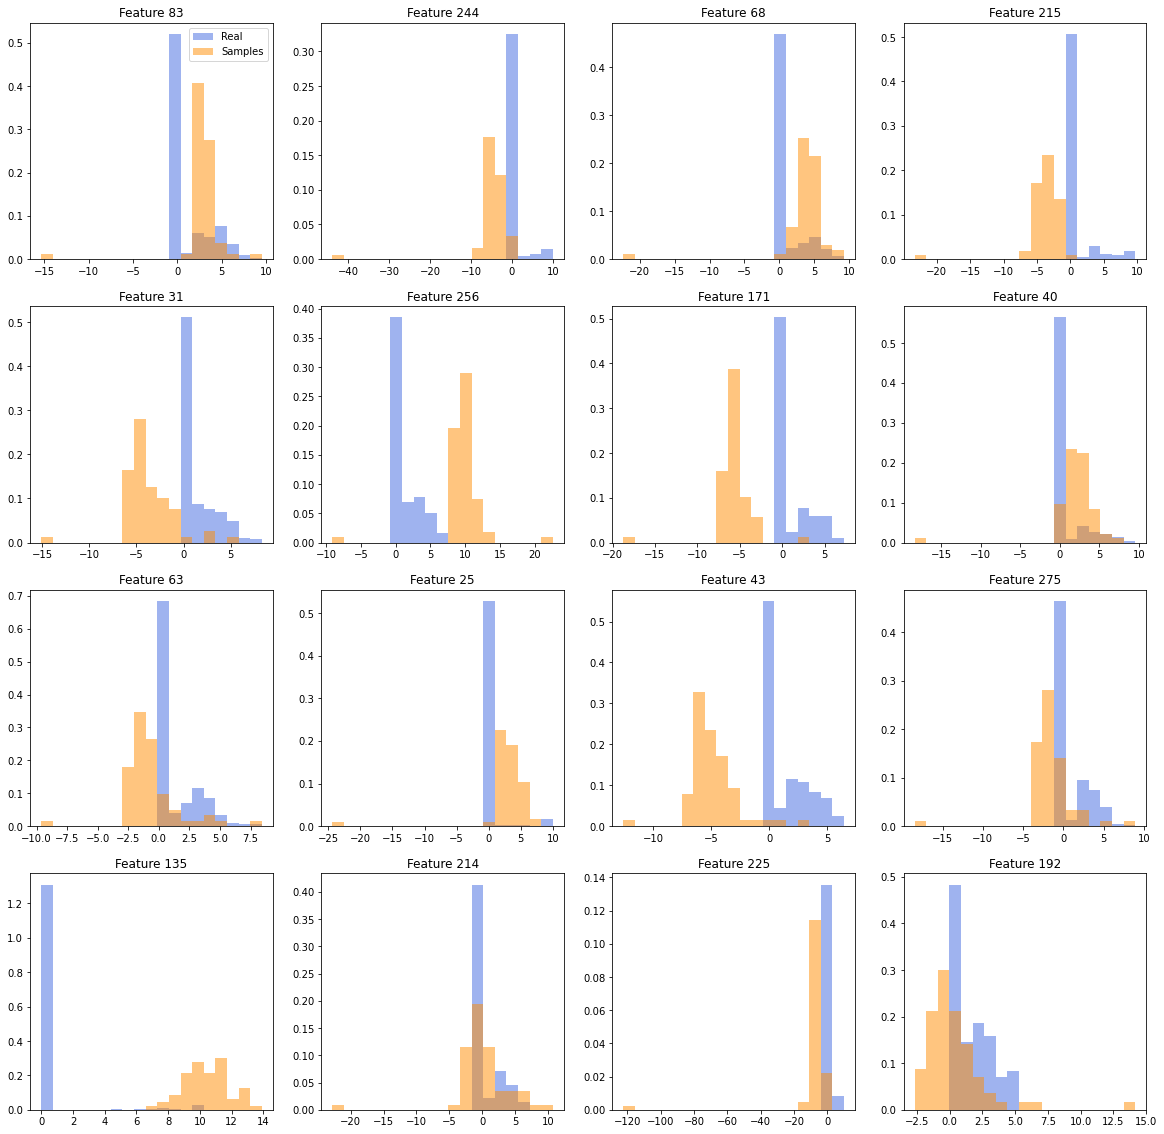

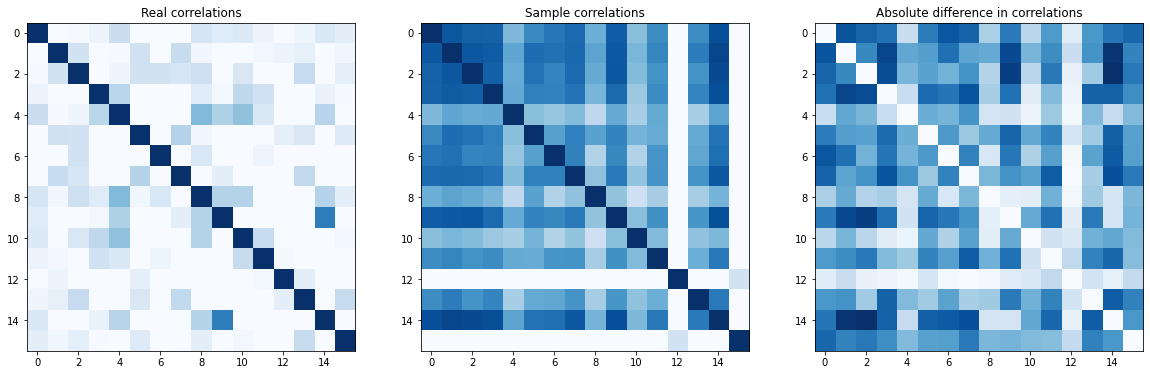

Class 1


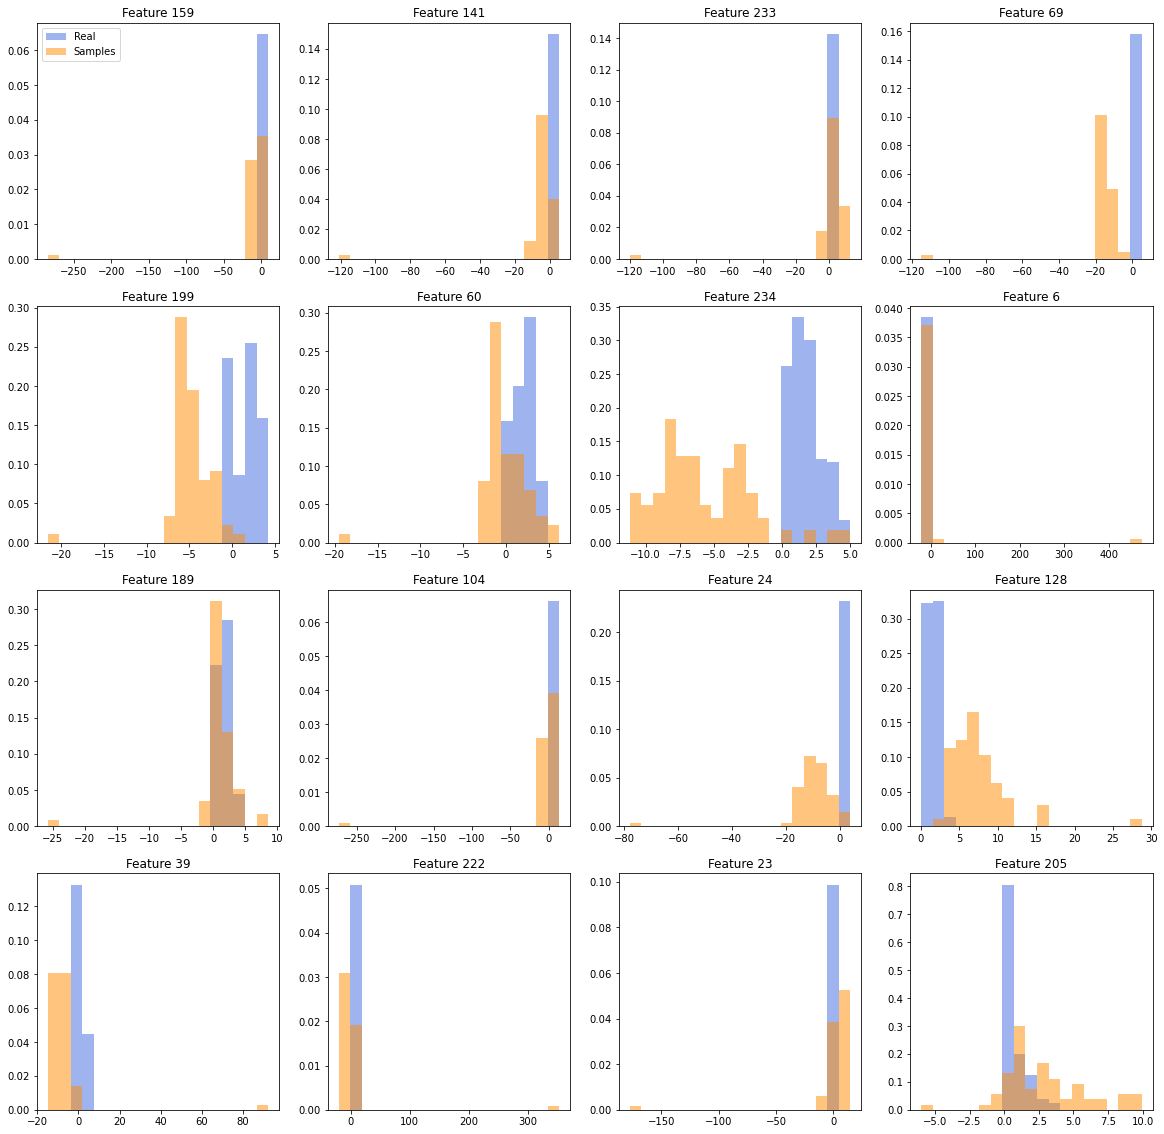

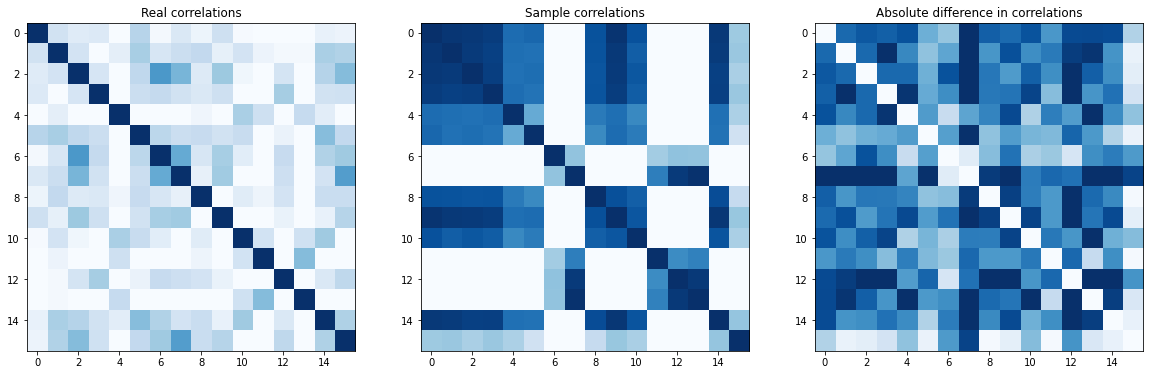

Class 2


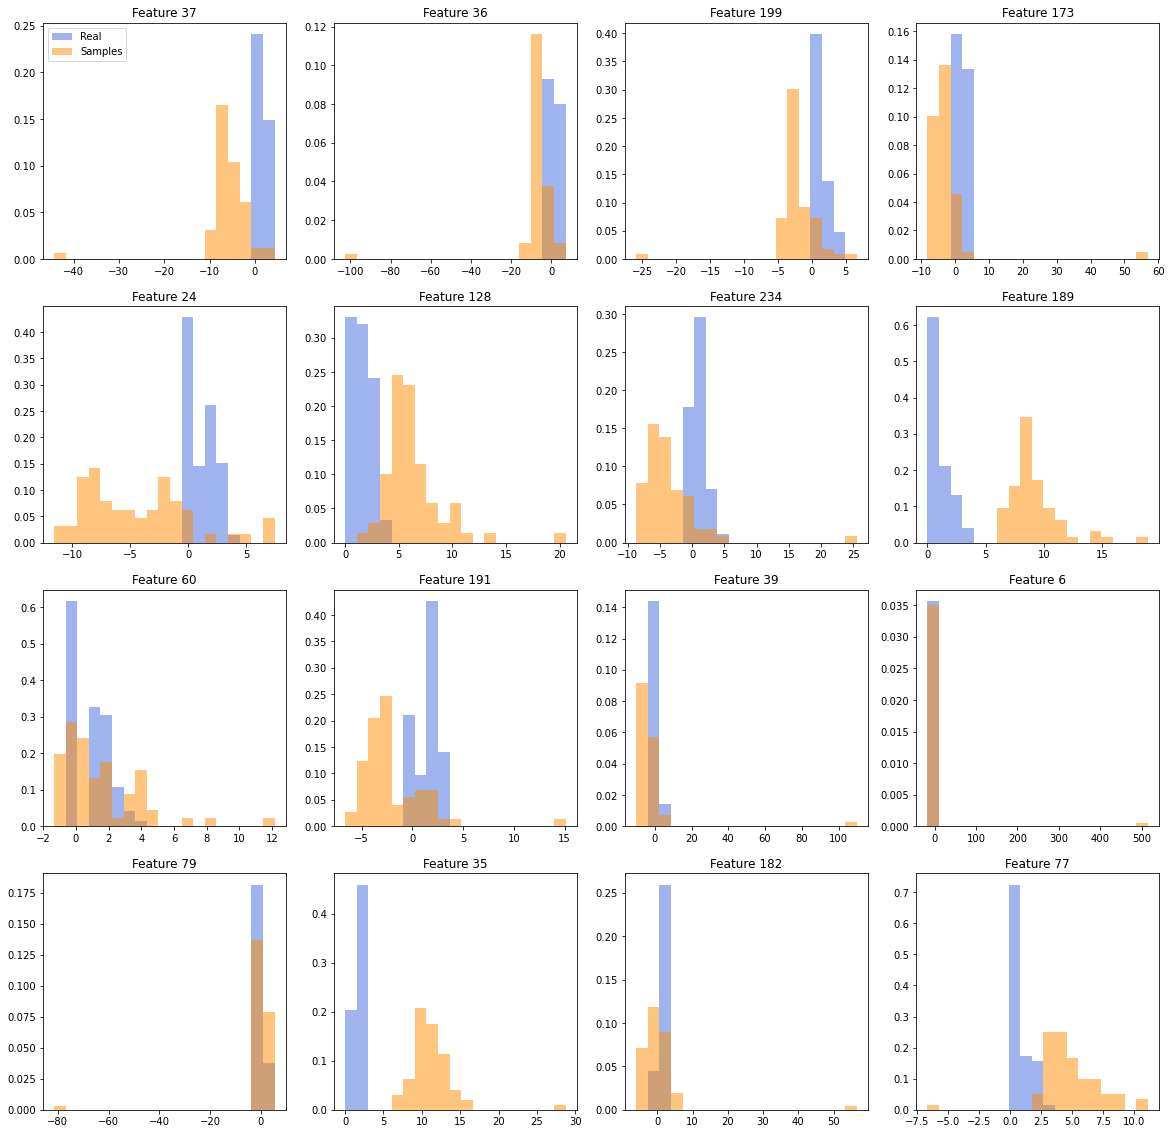

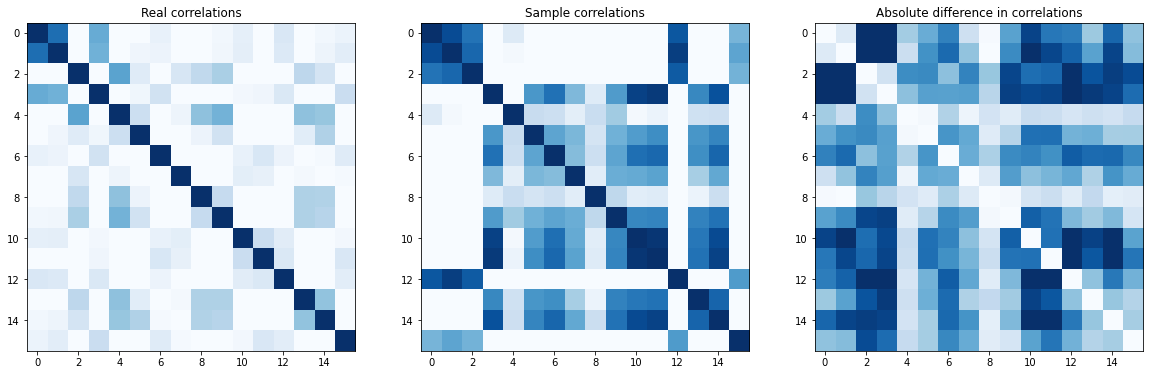

Class 3


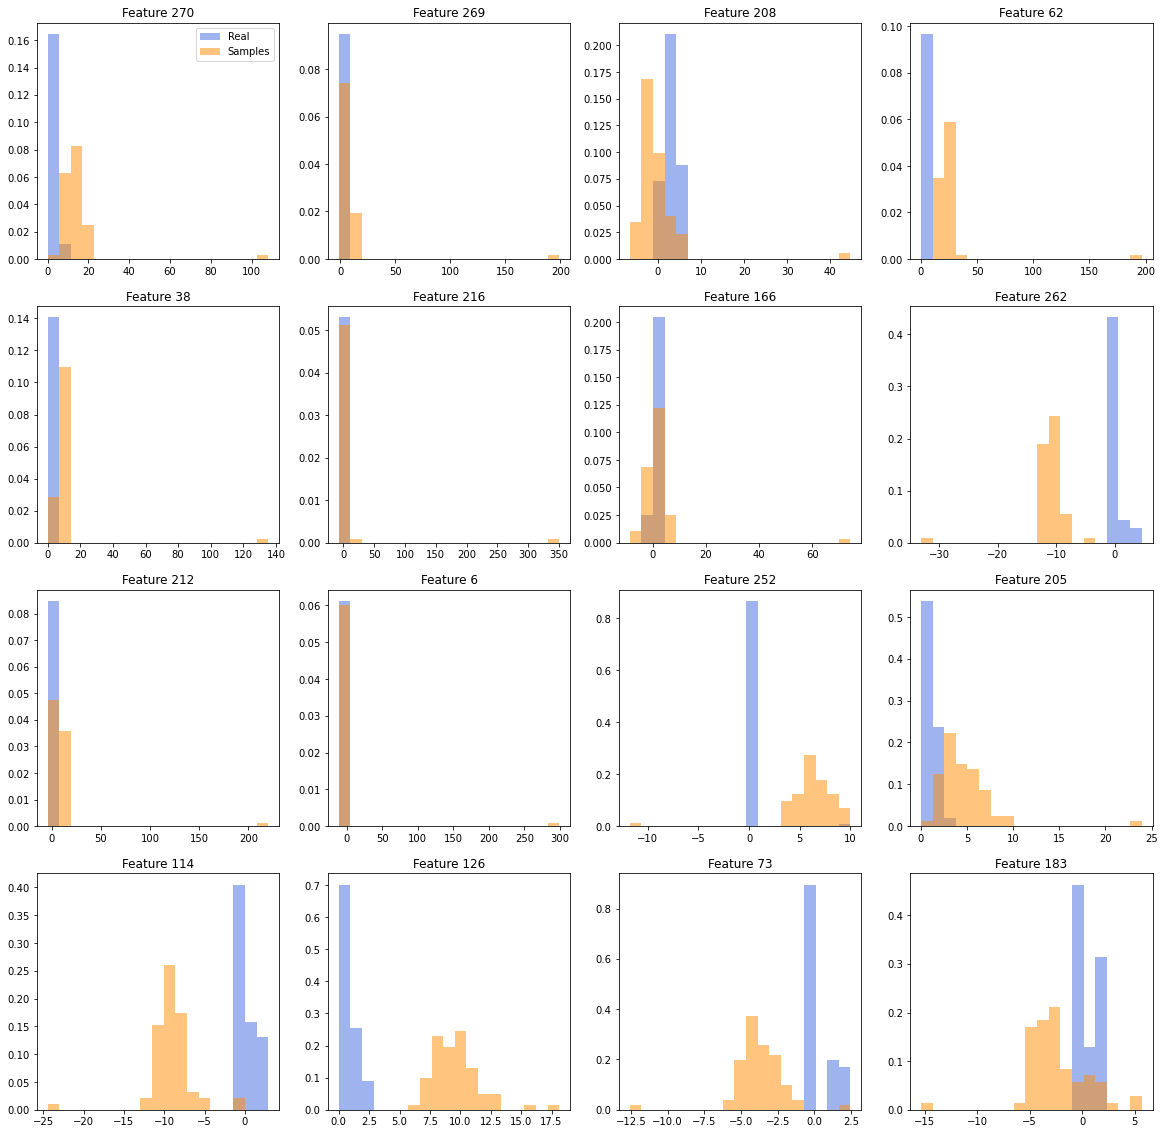

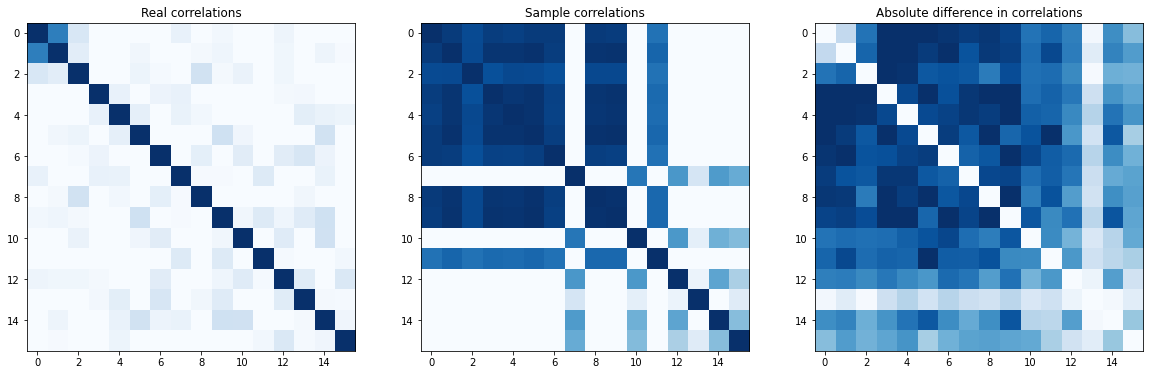

Class 4


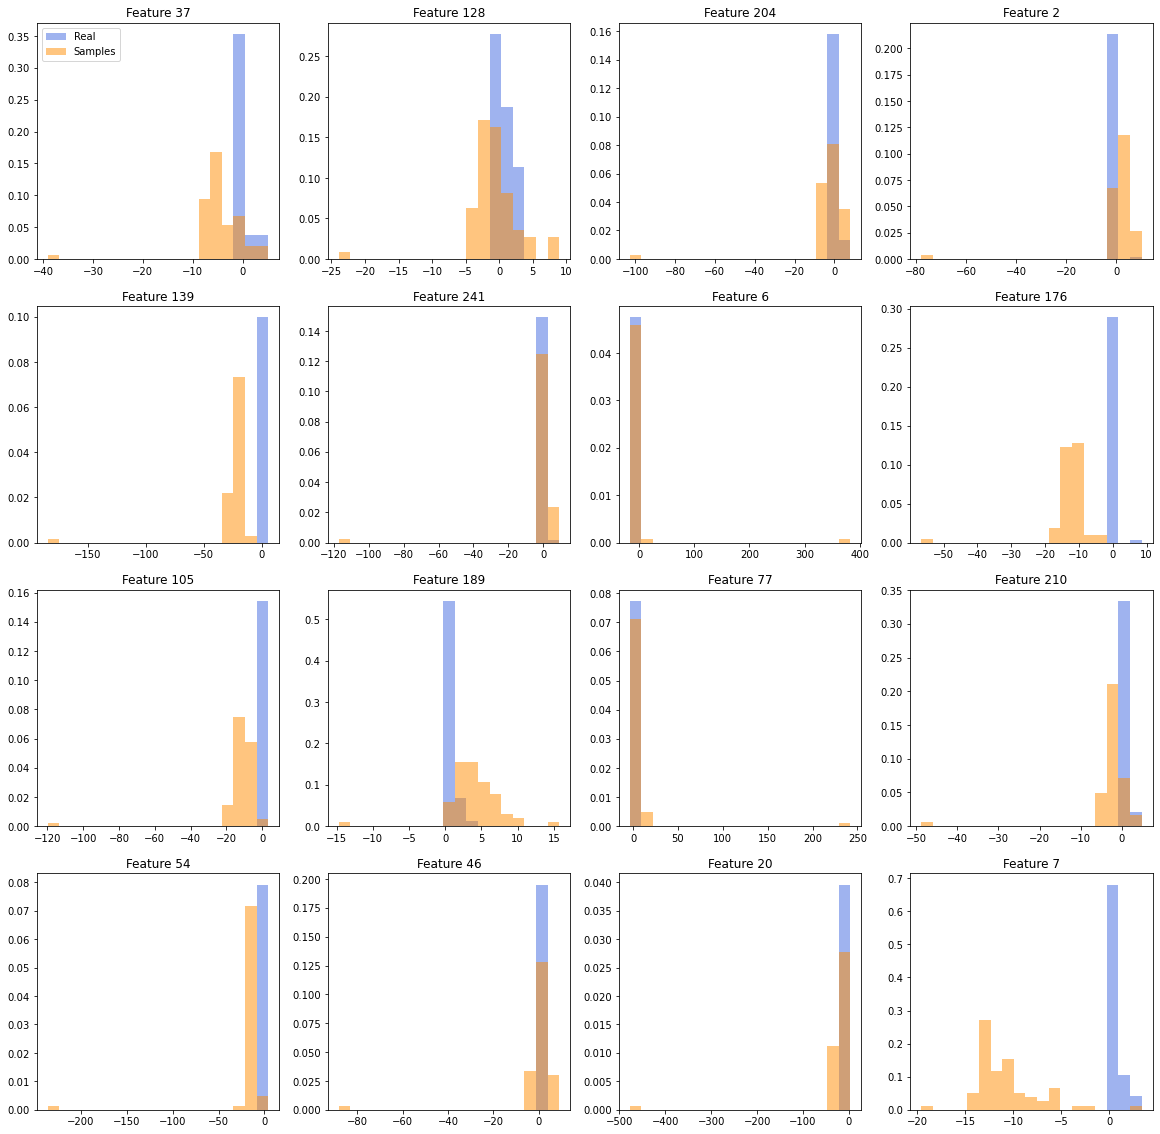

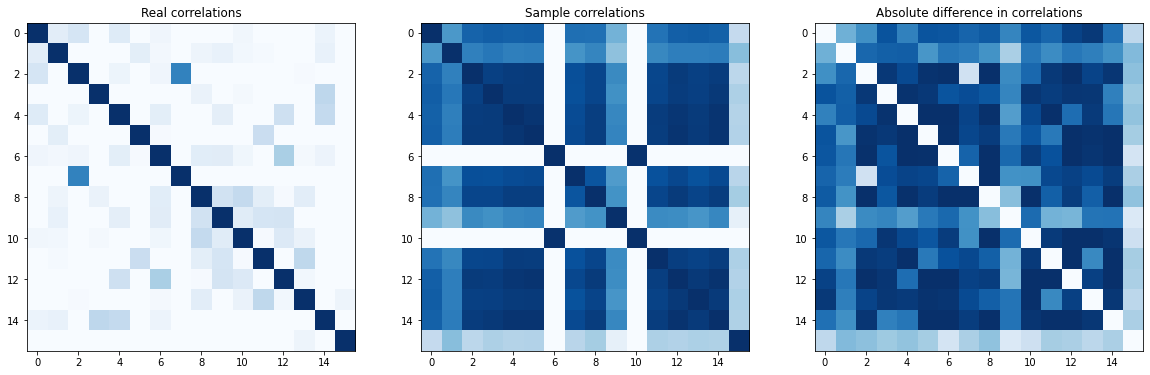

Class 5


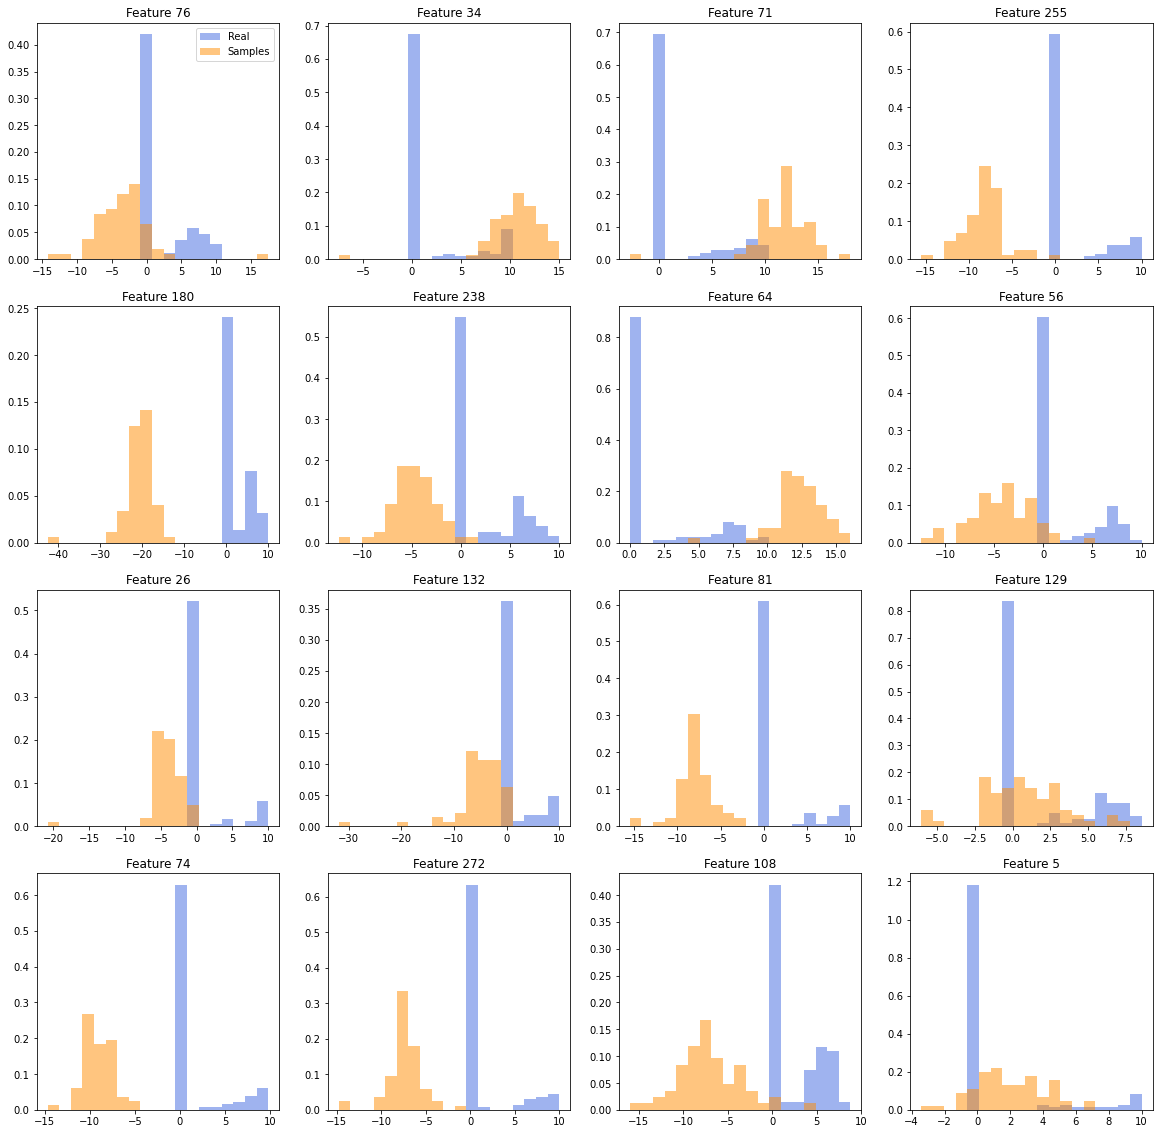

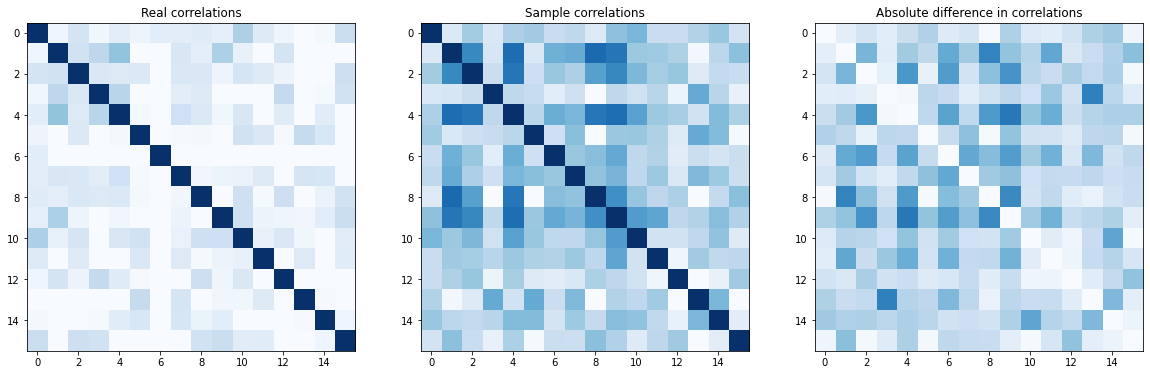

Class 7


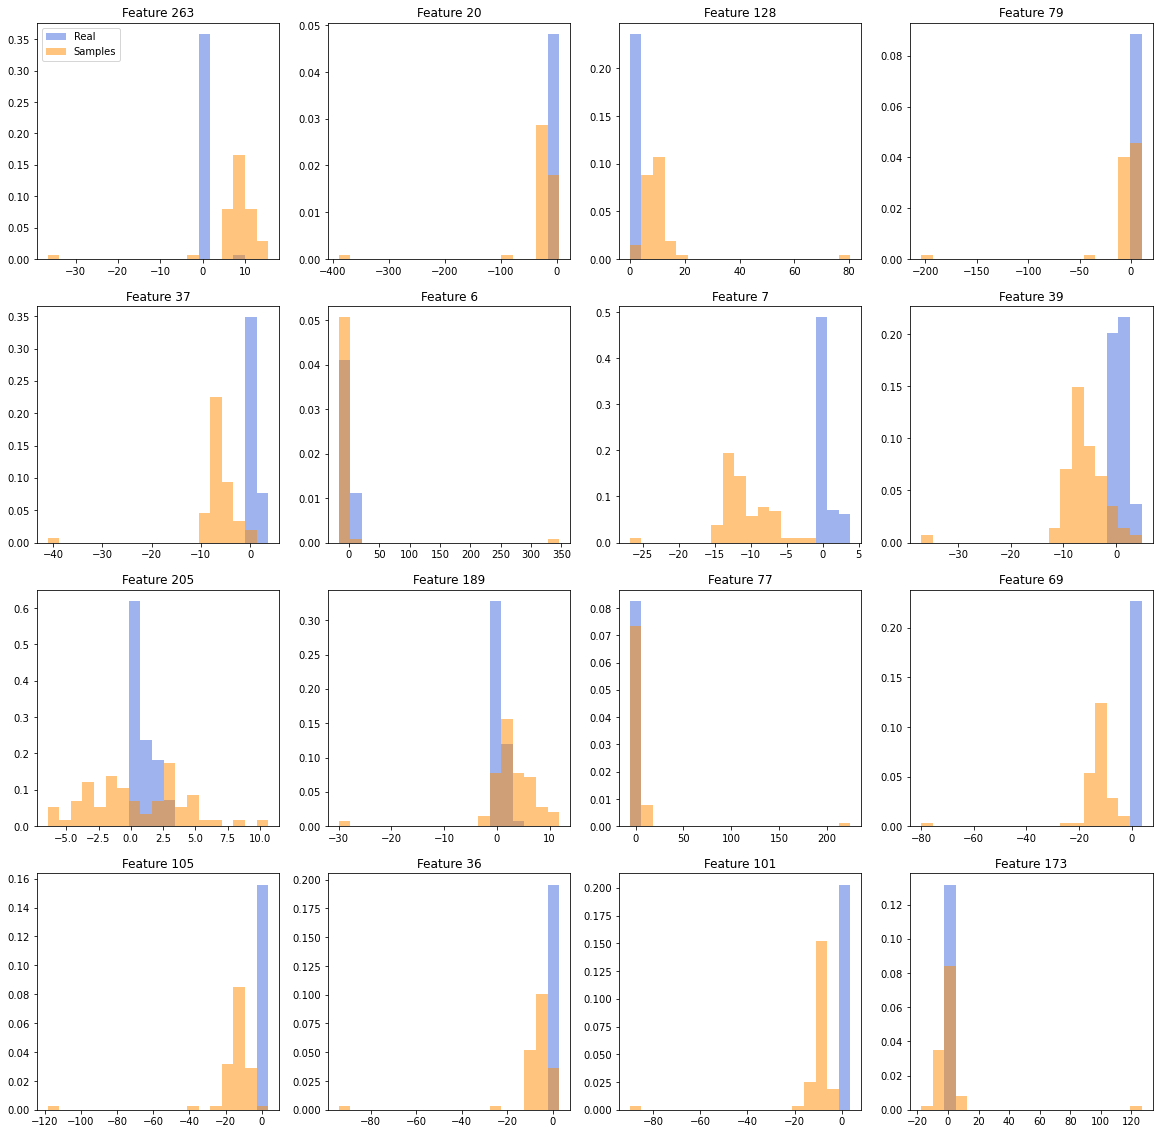

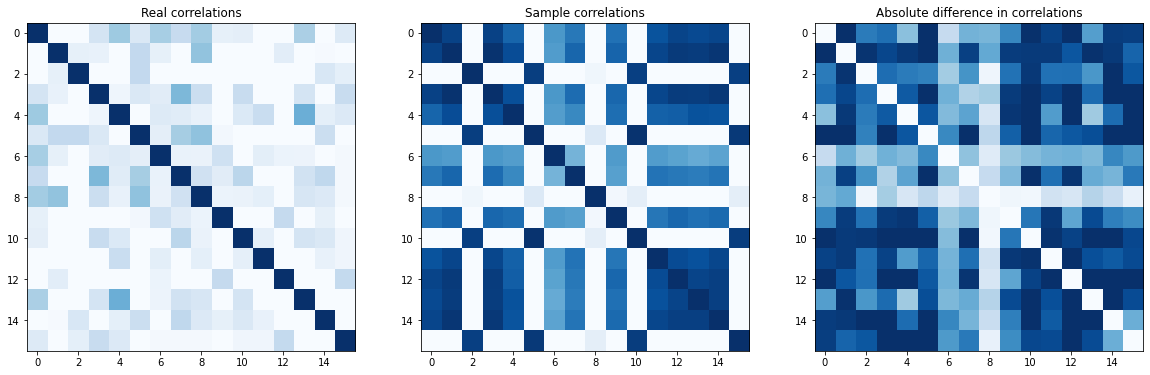

Class 10


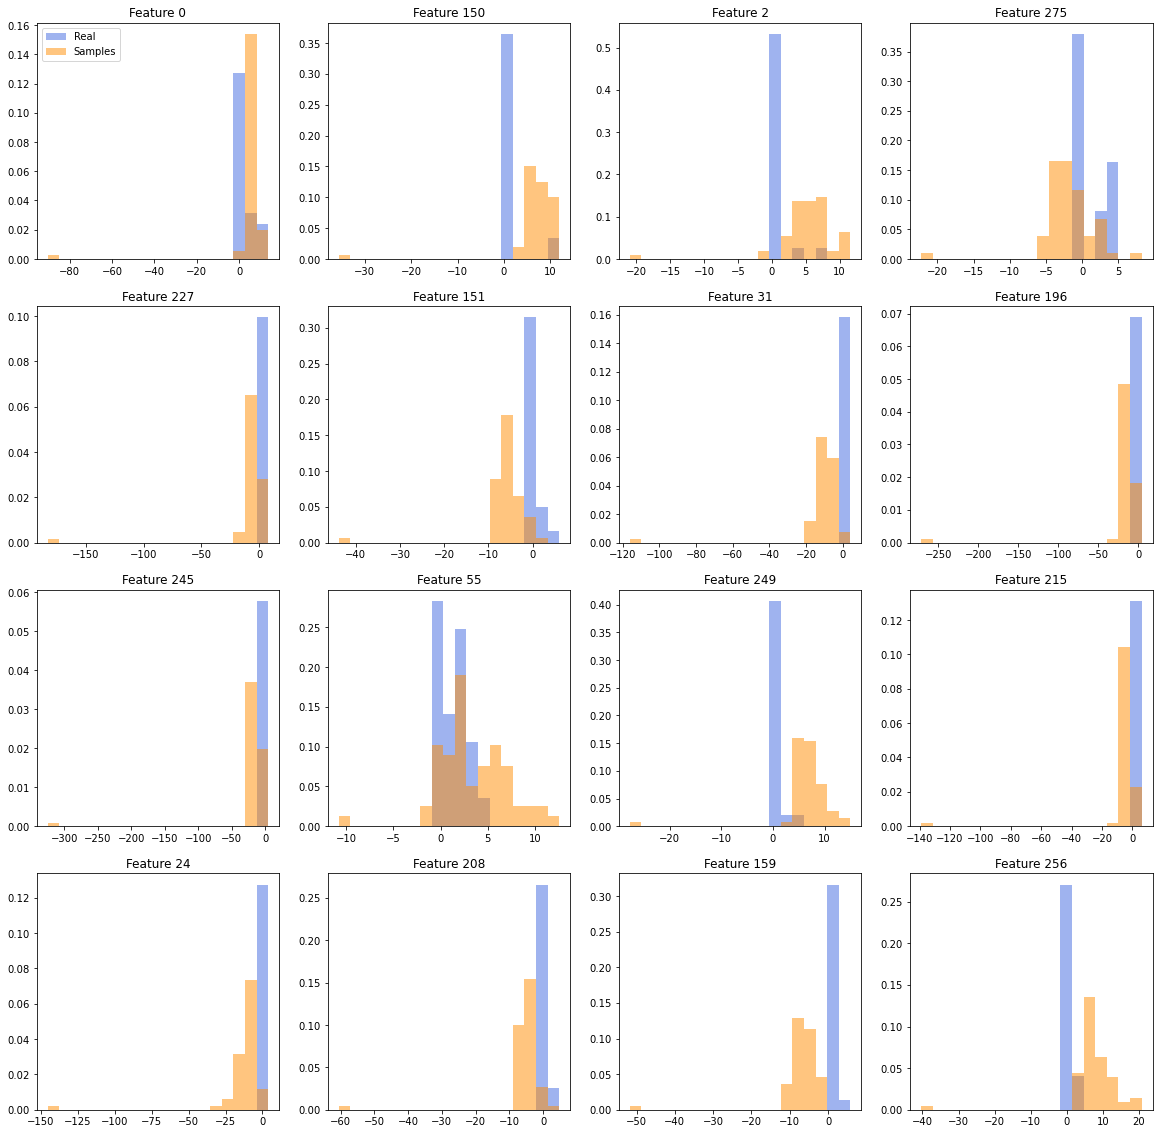

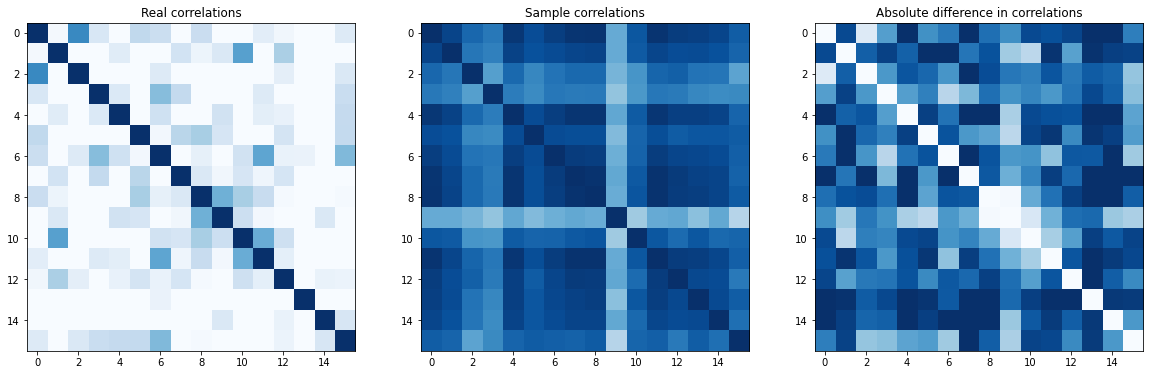

Class 12


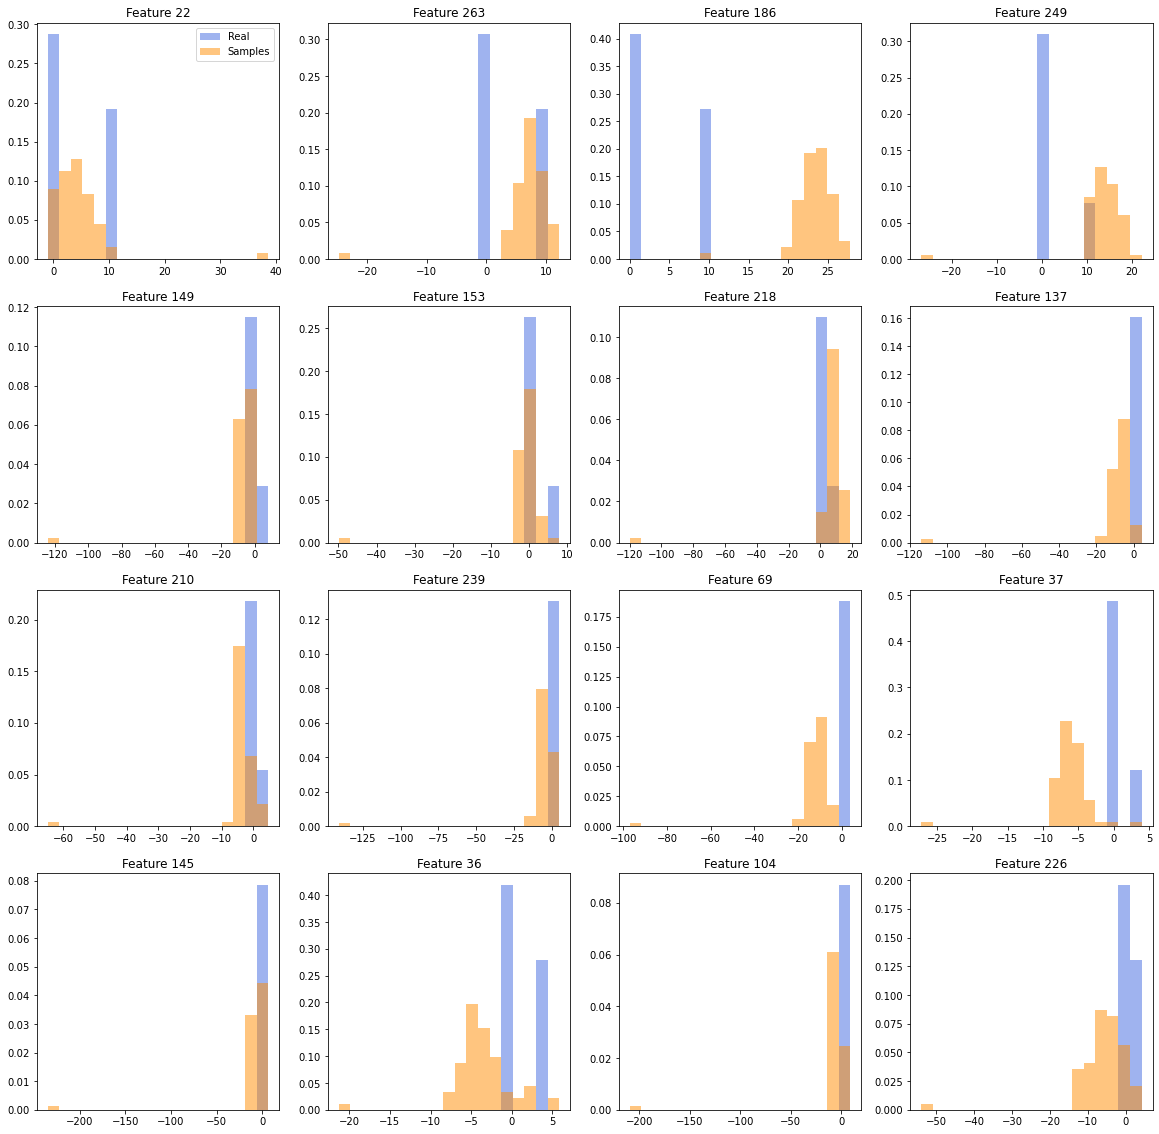

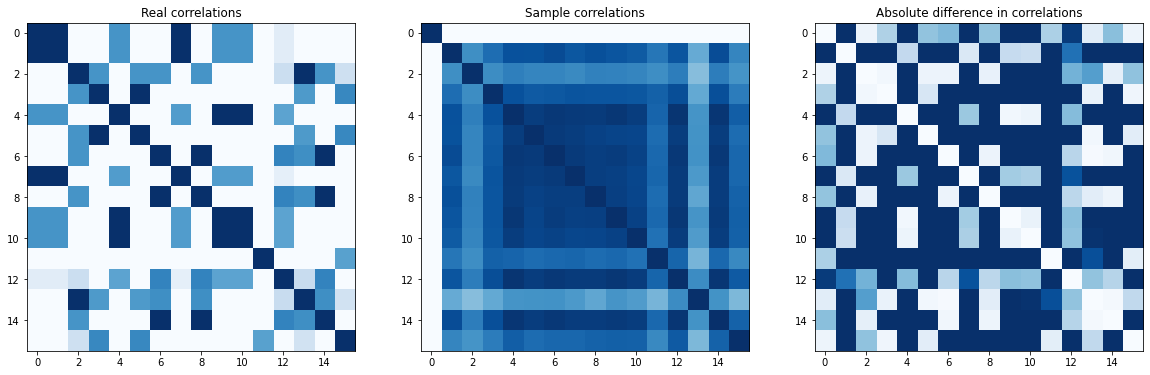

In [13]:
# For simplicity, sample a lot of inputs for the real data
data, targets = [], []
for _ in range(len(classes)):
    x, y = next(iter(data_loader))
    data.append(x.cpu().numpy())
    targets.append(y.cpu().numpy())
data = np.concatenate(data)
targets = np.concatenate(targets)

for class_to_sample in classes:
    print("Class %s" % class_to_sample)
    real = data[targets == class_to_sample]
    sample = samples[class_to_sample]
    
    # Decide which features to plot
    num_features = min(input_shape[0], 16)
    feature_inds = np.flip(np.argsort(np.std(real, axis=0)))[:num_features]
    # feature_inds = np.random.choice(input_shape[0], size=num_features, replace=False)
    
    num_cols = 4
    num_rows = int(np.ceil(num_features / num_cols))
    num_bins = 20

    # Plot feature values
    fig, ax = plt.subplots(ncols=num_cols, nrows=num_rows, figsize=(num_cols * 5, num_rows * 5))
    for i, f_i in enumerate(feature_inds):
        r, c = i // num_cols, i % num_cols
        real_vals = real[:, f_i]
        sample_vals = sample[:, f_i]
        all_vals = np.concatenate([real_vals, sample_vals])
        bins = np.linspace(np.min(all_vals), np.max(all_vals), num_bins)
        ax[r][c].hist(real_vals, bins=bins, color="royalblue", label="Real", density=True, alpha=0.5)
        ax[r][c].hist(sample_vals, bins=bins, color="darkorange", label="Samples", density=True, alpha=0.5)
        ax[r][c].set_title("Feature %d" % f_i)
    ax[0][0].legend()
    plt.show()

    # Compute and plot correlations
    real_corrs = np.empty((num_features, num_features))
    sample_corrs = np.empty_like(real_corrs)
    for i, f_i in enumerate(feature_inds):
        real_corrs[i, i] = 1
        sample_corrs[i, i] = 1
        for j in range(i):
            f_j = feature_inds[j]
            real_corrs[i, j] = scipy.stats.pearsonr(real[:, f_i], real[:, f_j])[0]
            real_corrs[j, i] = real_corrs[i, j]
            sample_corrs[i, j] = scipy.stats.pearsonr(sample[:, f_i], sample[:, f_j])[0]
            sample_corrs[j, i] = sample_corrs[i, j]

    fig, ax = plt.subplots(ncols=3, figsize=(20, 10))
    ax[0].imshow(real_corrs, cmap="Blues", vmin=0, vmax=1)
    ax[0].set_title("Real correlations")
    ax[1].imshow(sample_corrs, cmap="Blues", vmin=0, vmax=1)
    ax[1].set_title("Sample correlations")
    ax[2].imshow(np.abs(real_corrs - sample_corrs), cmap="Blues", vmin=0, vmax=1)
    ax[2].set_title("Absolute difference in correlations")
    plt.show()

### Transmutation

In [15]:
class_1, class_2 = 0, 1
branch_time = branch_defs[min(
    range(len(branch_defs)),
    key=(lambda i: branch_defs[i][1] if (
        class_1 in branch_defs[i][0] and class_2 in branch_defs[i][0]
    ) else float("inf"))
)][1]

orig_1 = torch.stack([
    dataset[i][0].to(DEVICE) for i in 
    np.random.choice(np.where(dataset.cell_cluster == class_1)[0], size=200, replace=False)
])
orig_2 = torch.stack([
    dataset[i][0].to(DEVICE) for i in 
    np.random.choice(np.where(dataset.cell_cluster == class_2)[0], size=200, replace=False)
])

time_steps = 10
all_t = np.linspace(0, branch_time, time_steps)
forward_1_to_2 = np.empty((len(all_t),) + orig_1.shape)
backward_1_to_2 = np.empty((len(all_t) - 1,) + orig_1.shape)
forward_2_to_1 = np.empty((len(all_t),) + orig_2.shape)
backward_2_to_1 = np.empty((len(all_t) - 1,) + orig_2.shape)
for t_i, t in enumerate(all_t):
    forward_1_to_2[t_i] = sde.forward(
        orig_1, torch.ones(len(orig_1)).to(DEVICE) * t
    )[0].cpu().numpy()
    forward_2_to_1[t_i] = sde.forward(
        orig_2, torch.ones(len(orig_2)).to(DEVICE) * t
    )[0].cpu().numpy()

all_t_flip = np.flip(all_t)
last_1_to_2 = torch.tensor(forward_1_to_2[-1]).to(DEVICE).float()
last_2_to_1 = torch.tensor(forward_2_to_1[-1]).to(DEVICE).float()
for t_i in range(len(all_t_flip) - 1):
    last_1_to_2 = generate.generate_continuous_branched_samples(
        model, sde, class_2, class_time_to_branch_tensor, sampler="pc",
        t_limit=all_t_flip[t_i], t_start=all_t_flip[t_i + 1],
        num_samples=orig_1.shape[0], initial_samples=last_1_to_2,
        num_steps=50
    )
    backward_1_to_2[t_i] = last_1_to_2.cpu().numpy()

    last_2_to_1 = generate.generate_continuous_branched_samples(
        model, sde, class_1, class_time_to_branch_tensor, sampler="pc",
        t_limit=all_t_flip[t_i], t_start=all_t_flip[t_i + 1],
        num_samples=orig_2.shape[0], initial_samples=last_2_to_1,
        num_steps=50
    )
    backward_2_to_1[t_i] = last_2_to_1.cpu().numpy()

orig_1, orig_2 = orig_1.cpu().numpy(), orig_2.cpu().numpy()
before_1_to_2, after_1_to_2 = forward_1_to_2[0], backward_1_to_2[-1]
before_2_to_1, after_2_to_1 = forward_2_to_1[0], backward_2_to_1[-1]
num_features = before_1_to_2.shape[1]

In [16]:
# Compute Wasserstein distance between predicted and true distributions
before_1_to_2_vs_true_dists = np.empty(num_features)
after_1_to_2_vs_true_dists = np.empty(num_features)
before_2_to_1_vs_true_dists = np.empty(num_features)
after_2_to_1_vs_true_dists = np.empty(num_features)
for i in range(num_features):
    before_1_to_2_vs_true_dists[i] = scipy.stats.wasserstein_distance(before_1_to_2[:, i], orig_1[:, i])
    after_1_to_2_vs_true_dists[i] = scipy.stats.wasserstein_distance(after_1_to_2[:, i], orig_2[:, i])
    before_2_to_1_vs_true_dists[i] = scipy.stats.wasserstein_distance(before_2_to_1[:, i], orig_2[:, i])
    after_2_to_1_vs_true_dists[i] = scipy.stats.wasserstein_distance(after_2_to_1[:, i], orig_1[:, i])

# Compute Wasserstein distance between different true distributions
true_feature_dists = np.empty(num_features)
for i in range(num_features):
    true_feature_dists[i] = scipy.stats.wasserstein_distance(orig_1[:, i], orig_2[:, i])

# Compute correlation of features before and after transmutation
corrs_1_to_2, corrs_2_to_1 = np.empty(num_features), np.empty(num_features)
for i in range(num_features):
    corrs_1_to_2[i] = scipy.stats.pearsonr(
        before_1_to_2[:, i], after_1_to_2[:, i]
    )[0]
    corrs_2_to_1[i] = scipy.stats.pearsonr(
        before_2_to_1[:, i], after_2_to_1[:, i]
    )[0]

/gstore/home/tsenga5/miniconda3/envs/scanpy/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [21]:
# Import gene names
with h5py.File(data_file, "r") as f:
    gene_names = f["gene_names"][:].astype(str)
    
genes_of_interest = np.array(["NFKB1", "NFKB2", "IRF1", "CXCR3", "CXCL10", "STAT1", "TLR4", "TGFB1", "IL1B", "IFNG", "TLR4", "TNFSF4", "IL1R2", "IL1B", "IL7R", "IL32"])

/gstore/home/tsenga5/miniconda3/envs/scanpy/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


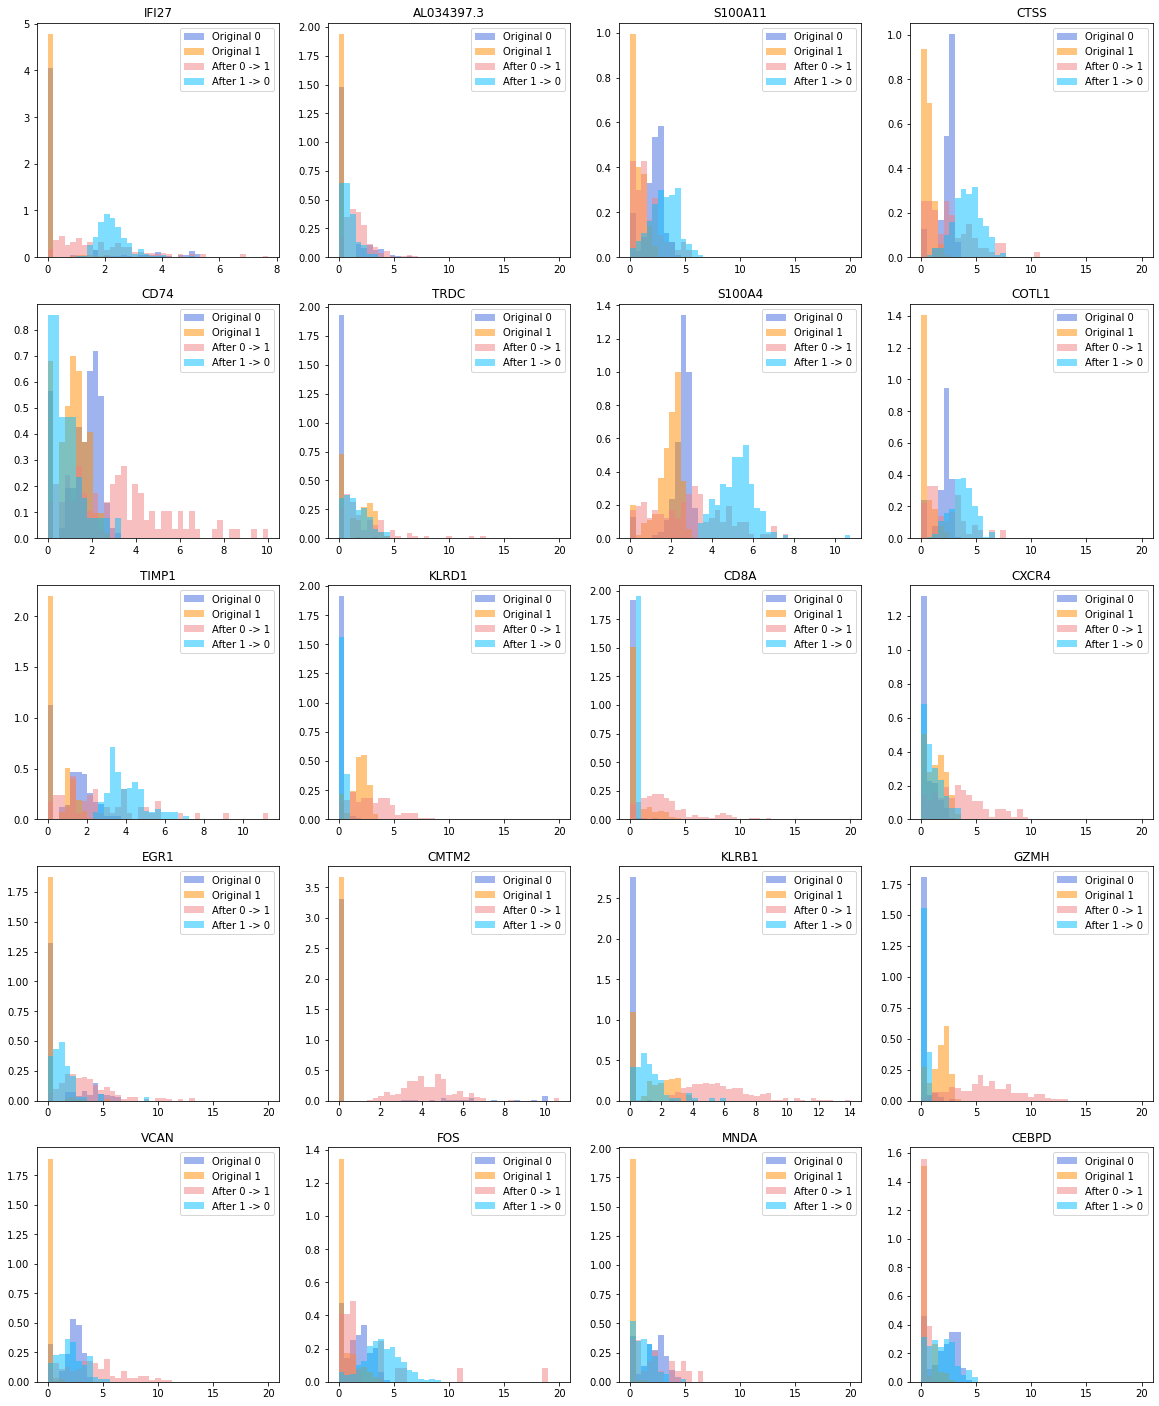

In [27]:
# Find genes where:
# 1) The distribution between classes is different
# 2) The predicted values are close to the true values
num_to_plot = 20

worst_pred_sim = np.max(np.stack([after_1_to_2_vs_true_dists, after_2_to_1_vs_true_dists], axis=1), axis=1)
feature_inds = np.argsort(worst_pred_sim)
feature_inds = feature_inds[true_feature_dists[feature_inds] > 0.5]
feature_inds = feature_inds[:num_to_plot]

num_cols = 4
num_rows = int(np.ceil(num_to_plot / num_cols))
num_bins = 40

# Plot feature values
fig, ax = plt.subplots(ncols=num_cols, nrows=num_rows, figsize=(num_cols * 5, num_rows * 5))
for i, f_i in enumerate(feature_inds):
    r, c = i // num_cols, i % num_cols
    orig_1_vals, orig_2_vals = orig_1[:, f_i], orig_2[:, f_i]
    after_1_to_2_vals, after_2_to_1_vals = after_1_to_2[:, f_i], after_2_to_1[:, f_i]

    all_vals = np.concatenate([orig_1_vals, orig_2_vals, after_1_to_2_vals, after_2_to_1_vals])
    bins = np.linspace(
        max(0, np.min(all_vals)), min(np.max(all_vals), 20), num_bins
    )
    ax[r][c].hist(orig_1_vals, bins=bins, color="royalblue", label=("Original %d" % class_1), density=True, alpha=0.5)
    ax[r][c].hist(orig_2_vals, bins=bins, color="darkorange", label=("Original %d" % class_2), density=True, alpha=0.5)
    ax[r][c].hist(after_1_to_2_vals, bins=bins, color="lightcoral", label=("After %d -> %d" % (class_1, class_2)), density=True, alpha=0.5)
    ax[r][c].hist(after_2_to_1_vals, bins=bins, color="deepskyblue", label=("After %d -> %d" % (class_2, class_1)), density=True, alpha=0.5)
    ax[r][c].set_title(gene_names[f_i])
    ax[r][c].legend()
plt.show()

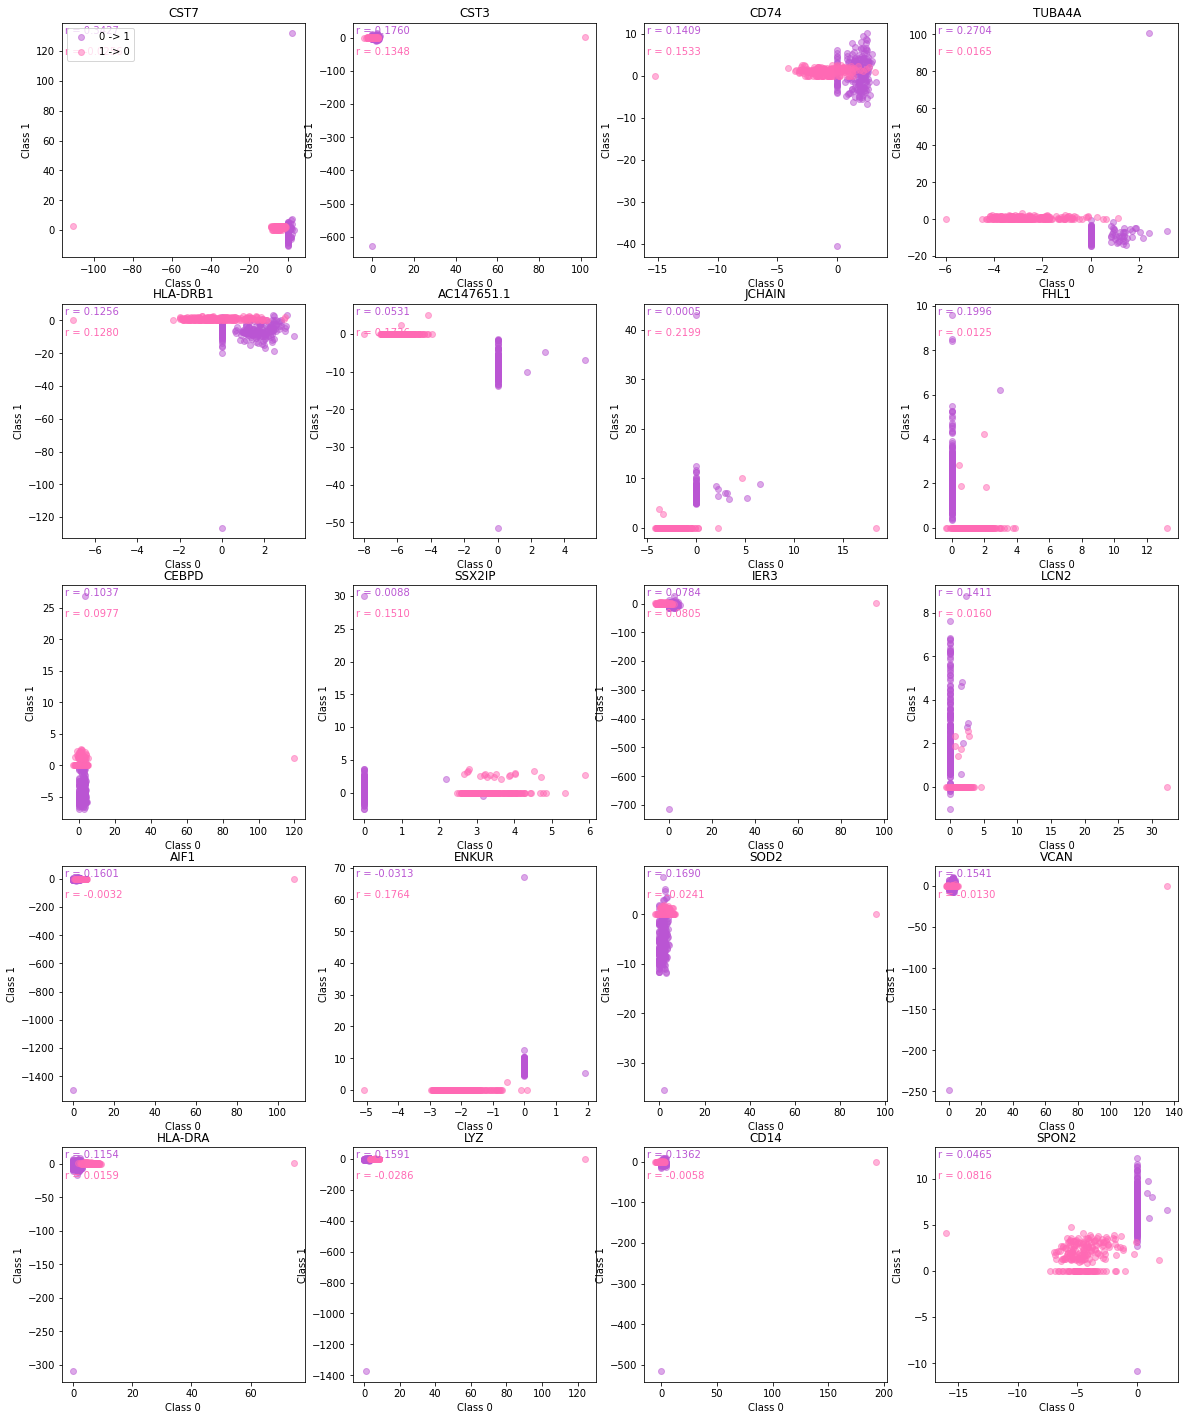

In [23]:
# Find genes where:
# 1) The correlation of before vs after transmutation is high
num_to_plot = 20

mean_corrs = np.mean(np.stack([corrs_1_to_2, corrs_2_to_1], axis=1), axis=1)
feature_inds = np.flip(np.argsort(mean_corrs))
feature_inds = feature_inds[np.isfinite(mean_corrs[feature_inds])]
feature_inds = feature_inds[:num_to_plot]

# feature_inds = [np.where(gene_names == gene)[0][0] for gene in genes_of_interest if gene in gene_names]

num_cols = 4
num_rows = int(np.ceil(num_to_plot / num_cols))

# Plot correlations
fig, ax = plt.subplots(ncols=num_cols, nrows=num_rows, figsize=(num_cols * 5, num_rows * 5))
for i, f_i in enumerate(feature_inds):
    r, c = i // num_cols, i % num_cols
    
    before_1_to_2_vals, after_1_to_2_vals = before_1_to_2[:, f_i], after_1_to_2[:, f_i]
    before_2_to_1_vals, after_2_to_1_vals = before_2_to_1[:, f_i], after_2_to_1[:, f_i]
    
    ax[r][c].scatter(before_1_to_2_vals, after_1_to_2_vals, alpha=0.5, color="mediumorchid", label=("%d -> %d" % (class_1, class_2)))
    ax[r][c].scatter(after_2_to_1_vals, before_2_to_1_vals, alpha=0.5, color="hotpink", label=("%d -> %d" % (class_2, class_1)))
    
    corr_1_to_2 = scipy.stats.pearsonr(before_1_to_2_vals, after_1_to_2_vals)[0]
    corr_2_to_1 = scipy.stats.pearsonr(before_2_to_1_vals, after_2_to_1_vals)[0]
    
    ax[r][c].text(
        0.01, 0.99, "r = %.4f" % corr_1_to_2,
        ha="left", va="top", transform=ax[r][c].transAxes, color="mediumorchid"
    )
    ax[r][c].text(
        0.01, 0.90, "r = %.4f" % corr_2_to_1,
        ha="left", va="top", transform=ax[r][c].transAxes, color="hotpink"
    )
    
    ax[r][c].set_xlabel("Class %d" % class_1)
    ax[r][c].set_ylabel("Class %d" % class_2)
    ax[r][c].set_title(gene_names[f_i])
ax[0][0].legend()
plt.show()